In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from Bio import PDB
import seaborn as sns
import json
import re
from io import StringIO
from Bio.SeqUtils import seq1
%matplotlib widget
import IPython
from IPython.core.display import Image
from Bio import pairwise2
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
from sklearn.cluster import KMeans
from Bio import SeqIO
from Bio.Align.Applications import ClustalOmegaCommandline

In [2]:
def colorprint(text, color):
    colors = {
        'red': '\033[91m',
        'green': '\033[92m',
        'yellow': '\033[93m',
        'blue': '\033[94m',
        'magenta': '\033[95m',
        'cyan': '\033[96m',
        'white': '\033[97m',
        'bold': '\033[1m',
        'underline': '\033[4m',
        'end': '\033[0m',
        'light_red': '\033[31m',
        'light_green': '\033[32m',
        'light_yellow': '\033[33m',
        'light_blue': '\033[34m',
        'light_magenta': '\033[35m',
        'light_cyan': '\033[36m',
        'light_gray': '\033[37m',
        'dark_gray': '\033[90m',
        'blink': '\033[5m',
        'reverse': '\033[7m',
        'hidden': '\033[8m',
        'bg_red': '\033[41m',
        'bg_green': '\033[42m',
        'bg_yellow': '\033[43m',
        'bg_blue': '\033[44m',
        'bg_magenta': '\033[45m',
        'bg_cyan': '\033[46m',
        'bg_light_gray': '\033[47m',
        'bg_dark_gray': '\033[100m',
        'bg_light_red': '\033[101m',
        'bg_light_green': '\033[102m',
        'bg_light_yellow': '\033[103m',
        'bg_light_blue': '\033[104m',
        'bg_light_magenta': '\033[105m',
        'bg_light_cyan': '\033[106m',
        'bg_white': '\033[107m'
    }
    if color in colors:
        print(colors[color] + text + colors['end'])
    else:
        print(text) 

        
from functools import wraps
from time import time

def measure(func):
    @wraps(func)
    def _time_it(*args, **kwargs):
        start = time()
        try:
            return func(*args, **kwargs)
        finally:
            end_ = time() - start
            mins, secs = divmod(end_, 60)
            print(f"Total execution time: {mins:.0f} mins {secs:.2f} secs")
    return _time_it


In [3]:
## import paths

input_dir = os.getcwd()+'\\'          # current working directory of input
output_dir = input_dir+'outdir\\'     # current output folder to store output of this notebook  

# Path to the Clustal Omega executable
clustalo_exe = input_dir+"clustal-omega-1.2.2-win64\\clustalo.exe"  # Update this with the actual path to clustalo.exe

## load the sequence data and look at the sequence lengths

In [4]:
seq_file = pd.read_csv(input_dir+'\\test data scientist shuffled sequences BioStrand.csv', index_col=0, header=0)
seq_file['seq_len'] = [len(x) for x in seq_file['original_sequence']]
print(seq_file)

                                     original_sequence  seq_len
id                                                             
0    GLSDGEWQQVLNVWGKVEADIAGHGQEVLIRLFTGHPETLEKFDKF...      153
1    QSVLTQPPSVSGAPGQRVTISCTGSRSNMGAGYDVHWYQLLPGAAP...      217
2    VQWSAEEKQLISSLWGKVNVAECGAEALARLLIVYPWTQRFFTSFG...      146
3    MHGQVDSSPGIWQLDCTHLEGKVILVAVHVASGYIEAEVIPAETGQ...      163
4    MHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPHTQRFFESFG...      146
..                                                 ...      ...
406  GSHMPKRGRPAATEVKIPKPRGRPPLPAGTNSKGPPDFSSDEEREP...      364
407  CVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFS...     1274
408  MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      154
409  VQLSGEEKAAVLALWDKVNEEEVGGEALGRLLVVYPWTQRFFDSFG...      145
410  MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      154

[411 rows x 2 columns]


## reading clusters computed by CDhit and the input fasta file

In [5]:
read_fasta_seq_all = SeqIO.parse(input_dir+'CDhit\\1711655125.fas.0', "fasta")
read_fasta_seq_ref = SeqIO.parse(input_dir+'CDhit\\1711655125.fas.1', "fasta")
fasta_sequences_all = {seq_record.id: seq_record.seq for seq_record in read_fasta_seq_all}
fasta_sequences_ref = {seq_record.id: seq_record.seq for seq_record in read_fasta_seq_ref}
print('TOTAL REFERENCE SEQUENCES', len(fasta_sequences_ref.keys()))
print('TOTAL SEQUENCES', len(fasta_sequences_all.keys()))

TOTAL REFERENCE SEQUENCES 45
TOTAL SEQUENCES 411


In [6]:
# for i, j in fasta_sequences_ref.items():
#     print(f'>{i}')
#     print(j)

In [6]:
import re

def read_cluster_file(filename):
    clusters = []
    with open(filename, 'r') as file:
        current_cluster = None
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if current_cluster is not None:
                    clusters.append(current_cluster)
                current_cluster = {'Cluster': line.split('>')[1], 'Data': [], 'Reference': []}
            else:
                parts = line.split('\t')
                sequence_info = parts[1].split('... at ')
#                 print(len(sequence_info))
                if len(sequence_info) < 2:
                    current_cluster['Reference'].append([int(sequence_info[0].split(',')[0][:-2]), sequence_info[0].split('>')[1], 'reference'])
                elif len(sequence_info) == 2:
                    identity = float(re.findall(r'\d+\.\d+', sequence_info[1])[0])
#                     print(type(identity))
#                     print(float(identity))
                    current_cluster['Data'].append([int(sequence_info[0].split(',')[0][:-2]), sequence_info[0].split('>')[1], float(identity)])
        if current_cluster is not None:
            clusters.append(current_cluster)
    return clusters

filename = input_dir+'CDhit\\1711655125.fas.1.clstr.sorted'
cluster_data = read_cluster_file(filename)



### create a dataframe from all the clusters including sequence and identity info
### create a dataframe of reference sequences in each cluster

In [7]:
clusters_dict = {}
reference_ids = []
for cluster in cluster_data:
#     print(cluster['Cluster'])
    # Define column names
    
    ref_list = cluster['Reference'][0]
    seq_id_ref = int(ref_list[1].split('... *')[0].split('_')[1])
#     print(seq_id_ref)
    ref_list.append(cluster['Cluster'])
    ref_list.append(seq_id_ref)
    ref_list.append(str(fasta_sequences_ref[f'sequence_{seq_id_ref}']))
#     print(fasta_sequences[f'sequence_{seq_id_ref}'])
#     print(ref_list)
    reference_ids.append(ref_list)
#     # Create DataFrame
    try:
        print(cluster['Cluster'])
        columns = ['seq_len (aa)', 'seq_id', 'identity (%)']
        df = pd.DataFrame(cluster['Data'], columns=columns)
        df['cluster_id'] = [cluster['Cluster'] for i in df.index]
        df['sequence_id'] = [int(x.split('_')[1]) for x in df['seq_id']]
# #         print(df)
        df['sequence'] = [''.join(fasta_sequences_all[f'sequence_{x}']) for x in df['sequence_id']]
#         print(df.head())
#         print()
#         print([fasta_sequences[f'sequence_{x}'] for x in df['sequence_id']])
        clusters_dict.update({cluster['Cluster']: df})
    except:
        pass

Cluster 0
Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5
Cluster 6
Cluster 7
Cluster 8
Cluster 9
Cluster 10
Cluster 11
Cluster 12
Cluster 13
Cluster 14
Cluster 15
Cluster 16
Cluster 17
Cluster 18
Cluster 19
Cluster 20
Cluster 21
Cluster 22
Cluster 23
Cluster 24
Cluster 25
Cluster 26
Cluster 27
Cluster 28
Cluster 29
Cluster 30
Cluster 31
Cluster 32
Cluster 33
Cluster 34
Cluster 35
Cluster 36
Cluster 37
Cluster 38
Cluster 39
Cluster 40
Cluster 41
Cluster 42
Cluster 43
Cluster 44


In [8]:
reference_df = pd.DataFrame([x for x in reference_ids])
reference_df.columns = ['seq_len (aa)', 'seq_id', 'identity (%)', 'cluster_id', 'sequence_id', 'sequence']
reference_df


seq_len (aa)             seq_id identity (%)  cluster_id  sequence_id  \
0            163  sequence_180... *    reference   Cluster 0          180   
1            147   sequence_26... *    reference   Cluster 1           26   
2            157   sequence_17... *    reference   Cluster 2           17   
3            243  sequence_115... *    reference   Cluster 3          115   
4            220   sequence_54... *    reference   Cluster 4           54   
5            183  sequence_210... *    reference   Cluster 5          210   
6           1310  sequence_332... *    reference   Cluster 6          332   
7            383  sequence_141... *    reference   Cluster 7          141   
8            221  sequence_349... *    reference   Cluster 8          349   
9            146    sequence_3... *    reference   Cluster 9            3   
10           217   sequence_72... *    reference  Cluster 10           72   
11           145   sequence_15... *    reference  Cluster 11           15   
12           290   sequence_41... *    reference  Cluster 12           41   
13           147   sequence_70... *    reference  Cluster 13           70   
14           217  sequence_345... *    reference  Cluster 14          345   
15           146   sequence_13... *    reference  Cluster 15           13   
16           146  sequence_214... *    reference  Cluster 16          214   
17           235  sequence_312... *    reference  Cluster 17          312   
18           216   sequence_92... *    reference  Cluster 18           92   
19           146   sequence_10... *    reference  Cluster 19           10   
20           146  sequence_132... *    reference  Cluster 20          132   
21           146  sequence_245... *    reference  Cluster 21          245   
22           146  sequence_285... *    reference  Cluster 22          285   
23          1212  sequence_276... *    reference  Cluster 23          276   
24           430  sequence_304... *    reference  Cluster 24          304   
25           364  sequence_407... *    reference  Cluster 25          407   
26           321  sequence_232... *    reference  Cluster 26          232   
27           245  sequence_120... *    reference  Cluster 27          120   
28           235  sequence_287... *    reference  Cluster 28          287   
29           216   sequence_44... *    reference  Cluster 29           44   
30           216  sequence_185... *    reference  Cluster 30          185   
31           216  sequence_230... *    reference  Cluster 31          230   
32           153   sequence_20... *    reference  Cluster 32           20   
33           153  sequence_211... *    reference  Cluster 33          211   
34           153  sequence_274... *    reference  Cluster 34          274   
35           146   sequence_35... *    reference  Cluster 35           35   
36           146  sequence_108... *    reference  Cluster 36          108   
37           146  sequence_173... *    reference  Cluster 37          173   
38           146  sequence_278... *    reference  Cluster 38          278   
39           146  sequence_289... *    reference  Cluster 39          289   
40           146  sequence_316... *    reference  Cluster 40          316   
41           146  sequence_340... *    reference  Cluster 41          340   
42           146  sequence_384... *    reference  Cluster 42          384   
43           146  sequence_390... *    reference  Cluster 43          390   
44           145  sequence_267... *    reference  Cluster 44          267   

                                             sequence  
0   MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...  
1   MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESF...  
2   GSHMGLSDGEWQLVLNVWGKVEADVAGHGQEVLIRLFTGHPETLEK...  
3   KLAATMVLQTQVFISLLLWISGAYGQSVLTQPPSASGTPGQRVTIS...  
4   QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYAVHWYQQLPGTAP...  
5   MGSSHHHHHHSSGLVPRGSHMHGQVDCSPGIWQLDCTHLEGKVILV...  
6   MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...  
7   MGSSHHHHH

## remove duplicates

In [423]:
plt.close('all')
identity_all_clusters = {}
for i in clusters_dict.keys():
    print(i)
#     print('REFERENCE SEQUENCE')
    colorprint(reference_df[reference_df['cluster_id'] == i]['sequence'].values[0], 'blue')
    list_seq = clusters_dict[i]['sequence_id']
#     print(list_seq)
    
    clusterseq_df = clusters_dict[i]
    
#     print(clusterseq_df.head())
#     print(len(clusterseq_df['sequence'].unique()), clusterseq_df.shape[0])
#     for id_ in list_seq:
# #         print(id_)
#         index_orig = id_ - 1
#     #         
#         colorprint(clusterseq_df[clusterseq_df['sequence_id'] == id_]['sequence'].values[0], 'green')
#         colorprint(seq_file.iloc[index_orig]['original_sequence'], 'red')
#         print()
    
#     print()


Cluster 0
MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQGGSGHHHHHH
Cluster 1
MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH
Cluster 2
GSHMGLSDGEWQLVLNVWGKVEADVAGHGQEVLIRLFTGHPETLEKFDKFKHLKTEDEMKASEDLKKHGNTVLTALGGILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISDAIIHVLQSKHPGDFGADAQGAMNKALELFRNDIAAKYKELGFQG
Cluster 3
KLAATMVLQTQVFISLLLWISGAYGQSVLTQPPSASGTPGQRVTISCSGSSSNIGTNTVNWYQQLPGTAPKLLIYRNYQRPSGVPDRFSGSKSGTSASLAISGLRSEDEADYYCAAWDDSLSGPHVVFGGGTKLTVLGQPKAAPSVTLFPPSSEELQANKATLVCLISDFYPGAVTVAWKADSSPVKAGVETTTPSKQSNNKYAASSYLSLTPEQWKSHRSYSCQVTHEGSTVEKTVAPTECS
Cluster 4
QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYAVHWYQQLPGTAPKLLISGNSNRPSGVPDRFSGSKSGTSASLAITGLQAEDEADYYCQSYDSSLSGSVFGGGTKLTVLGQPKAAPSVTLFPPSSEELQANKATLVCLISDFYPGAVTVAWKADSSPVKAGVETTTPSKQSNNKYAASSYLSLTPEQWKSHRSYSCQVTHEGSTVEKTVAPTECSARQ
Cluster 5
MGSSH

In [9]:
identity_all_clusters = pd.DataFrame({x: y['identity (%)'] for x, y in clusters_dict.items()})
print(identity_all_clusters)

    Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 5  \
0       98.70      98.63      92.81      93.06      94.01      96.32   
1       98.70      98.63      94.12      95.31      95.39     100.00   
2       96.75      98.63      94.77      94.42      94.47      96.99   
3       98.70      99.32      94.77      95.37      93.27      95.83   
4       98.70      98.63      90.85      93.06      96.31      97.60   
..        ...        ...        ...        ...        ...        ...   
91     100.00        NaN        NaN        NaN        NaN        NaN   
92      98.68        NaN        NaN        NaN        NaN        NaN   
93      98.04        NaN        NaN        NaN        NaN        NaN   
94      98.70        NaN        NaN        NaN        NaN        NaN   
95      98.70        NaN        NaN        NaN        NaN        NaN   

    Cluster 6  Cluster 7  Cluster 8  Cluster 9  ...  Cluster 13  Cluster 14  \
0       96.24      97.39      91.36      92.47  ...     

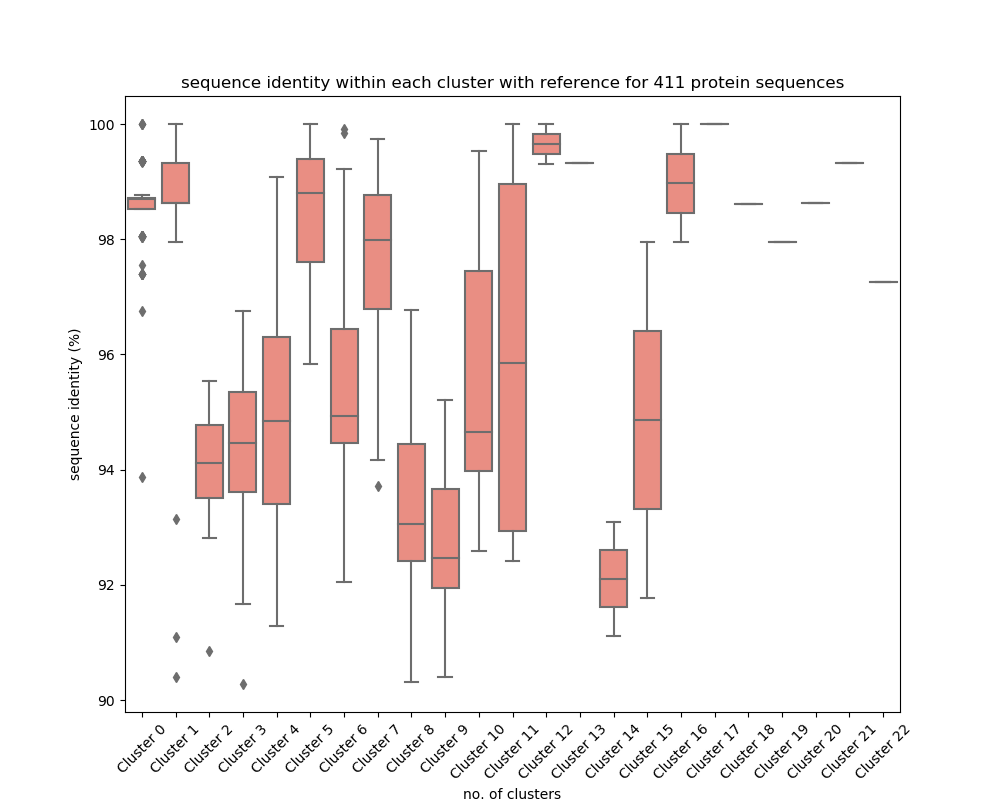

In [11]:
plt.close()
# for x in identity_all_clusters.columns:
# Convert the DataFrame to long format
identity_all_clusters_long = identity_all_clusters.melt(var_name='Columns', value_name='Values')
# print(identity_all_clusters_long)

fig, ax = plt.subplots(figsize=(10, 8))
# Create a boxplot with multiple columns using Seaborn
sns.boxplot(data=identity_all_clusters_long, x='Columns', y='Values', color='salmon')

# Set plot title and labels
ax.set_title('sequence identity within each cluster with reference for 411 protein sequences')
ax.set_ylabel('sequence identity (%)')
ax.set_xlabel('no. of clusters')
plt.xticks(rotation=45,fontsize=10)
# plt.xticklabels(fontsize=10)
plt.show()

In [10]:


@measure
def identity_ref(reference_df, option):
    if option == 'local':
        num_sequences = reference_df.shape[0]
        # Compute alignment scores for upper triangular matrix
        alignment_scores = []
        alignments_pairwise = {}
        for i in range(num_sequences):
            for j in range(i + 1, num_sequences):  # Only iterate over upper triangular part
        #         print(i, j)
                pair_i_name = '_'.join([format(a) for a in reference_df.iloc[i][['cluster_id','sequence_id']].values])
                pair_j_name = '_'.join([format(a) for a in reference_df.iloc[j][['cluster_id','sequence_id']].values])
        #         print(pair_i_name, pair_j_name)
                protein_i = reference_df.iloc[i]['sequence']
                protein_j = reference_df.iloc[j]['sequence']

                alignment = pairwise2.align.localxx(protein_i, protein_j)
                alignment_score = alignment[0].score
                similarity = alignment_score / max(len(protein_i), len(protein_j))
                alignment_scores.append((i, j, similarity))
                alignments_pairwise.update({pair_i_name+'_'+pair_j_name: alignment})
        return alignment_scores, alignments_pairwise
    elif option == 'global':
        num_sequences = reference_df.shape[0]
        # Compute alignment scores for upper triangular matrix
        alignment_scores = []
        alignments_pairwise = {}
        for i in range(num_sequences):
            for j in range(i + 1, num_sequences):  # Only iterate over upper triangular part
        #         print(i, j)
                pair_i_name = '_'.join([format(a) for a in reference_df.iloc[i][['cluster_id','sequence_id']].values])
                pair_j_name = '_'.join([format(a) for a in reference_df.iloc[j][['cluster_id','sequence_id']].values])
        #         print(pair_i_name, pair_j_name)
                protein_i = reference_df.iloc[i]['sequence']
                protein_j = reference_df.iloc[j]['sequence']

                alignment = pairwise2.align.globalxx(protein_i, protein_j)
                alignment_score = alignment[0].score
                similarity = alignment_score / max(len(protein_i), len(protein_j))
                alignment_scores.append((i, j, similarity))
                alignments_pairwise.update({pair_i_name+'_'+pair_j_name: alignment})
        return alignment_scores, alignments_pairwise

In [548]:
align_score_global, align_dict_global = identity_ref(reference_df, 'global')


# # Convert alignment score_globals to DataFrame
pairwise_score_global = pd.DataFrame(align_score_global, columns=['Sequence1', 'Sequence2', 'Alignment_score_global'])
# # Create an empty DataFrame to store the alignment score_globals in a symmetric matrix_global format
alignment_matrix_global = pd.DataFrame(index=range(num_sequences), columns=range(num_sequences), dtype=float)

# Fill the upper triangular part of the matrix_global with alignment score_globals
for index, row in pairwise_score_global.iterrows():
    sequence1, sequence2, alignment_score_global = row['Sequence1'], row['Sequence2'], row['Alignment_score_global']
    alignment_matrix_global.loc[sequence1, sequence2] = alignment_score_global

# Fill the lower triangular part of the matrix_global with NaN values
alignment_matrix_global = alignment_matrix_global.where(np.triu(np.ones(alignment_matrix_global.shape), k=1).astype(bool))
# print(alignment_matrix_global)

# Copy upper triangular part into lower triangular part
alignment_matrix_global.values[np.tril_indices_from(alignment_matrix_global, -1)] = alignment_matrix_global.values.T[np.tril_indices_from(alignment_matrix_global, -1)]

# Set diagonal elements to 1
np.fill_diagonal(alignment_matrix_global.values, 1)

Total execution time: 0 mins 22.15 secs


In [549]:
align_score_local, align_dict_local = identity_ref(reference_df, 'local')

# # Convert alignment score_locals to DataFrame
pairwise_score_local = pd.DataFrame(align_score_local, columns=['Sequence1', 'Sequence2', 'Alignment_score_local'])
# # Create an empty DataFrame to store the alignment score_locals in a symmetric matrix_local format
alignment_matrix_local = pd.DataFrame(index=range(num_sequences), columns=range(num_sequences), dtype=float)

# Fill the upper triangular part of the matrix_local with alignment score_locals
for index, row in pairwise_score_local.iterrows():
    sequence1, sequence2, alignment_score_local = row['Sequence1'], row['Sequence2'], row['Alignment_score_local']
    alignment_matrix_local.loc[sequence1, sequence2] = alignment_score_local

# Fill the lower triangular part of the matrix_local with NaN values
alignment_matrix_local = alignment_matrix_local.where(np.triu(np.ones(alignment_matrix_local.shape), k=1).astype(bool))
# print(alignment_matrix_local)

# Copy upper triangular part into lower triangular part
alignment_matrix_local.values[np.tril_indices_from(alignment_matrix_local, -1)] = alignment_matrix_local.values.T[np.tril_indices_from(alignment_matrix_local, -1)]

# Set diagonal elements to 1
np.fill_diagonal(alignment_matrix_local.values, 1)

Total execution time: 0 mins 46.91 secs


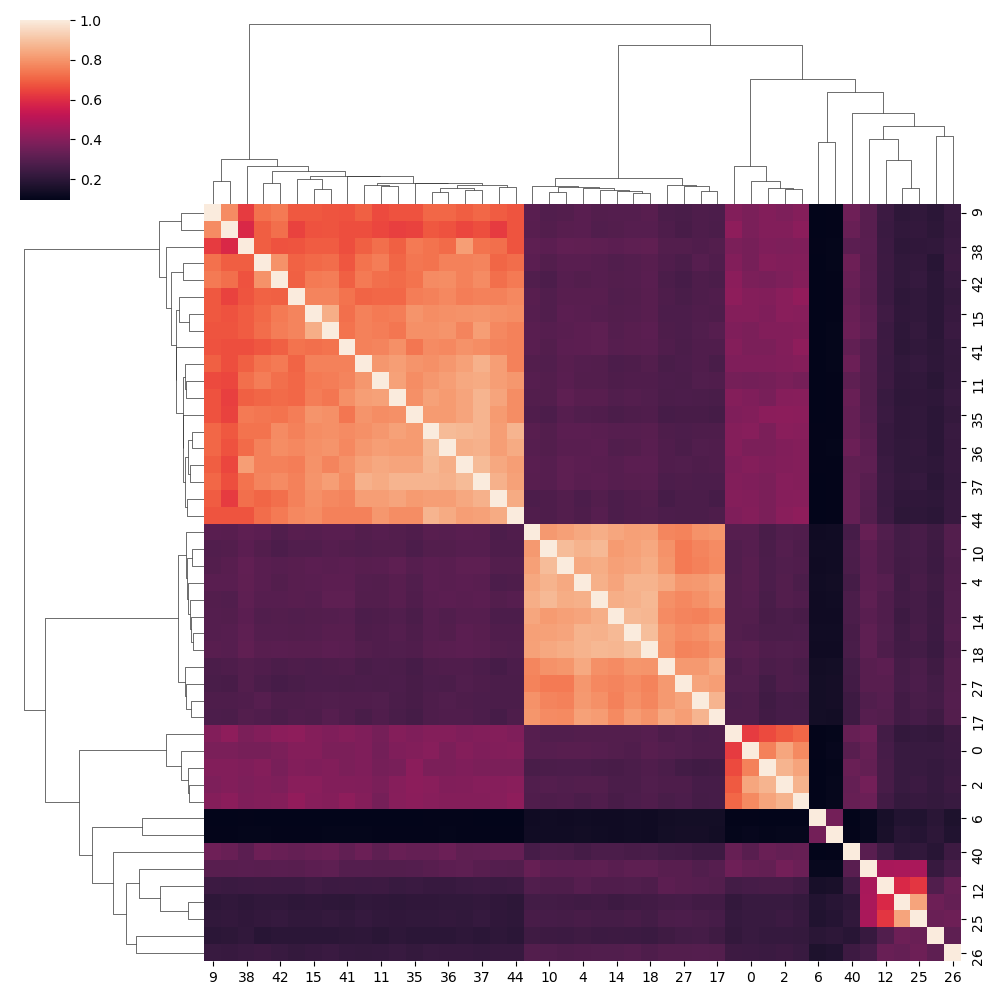

In [550]:
plt.close()
sns.clustermap(alignment_matrix_global)
plt.show()

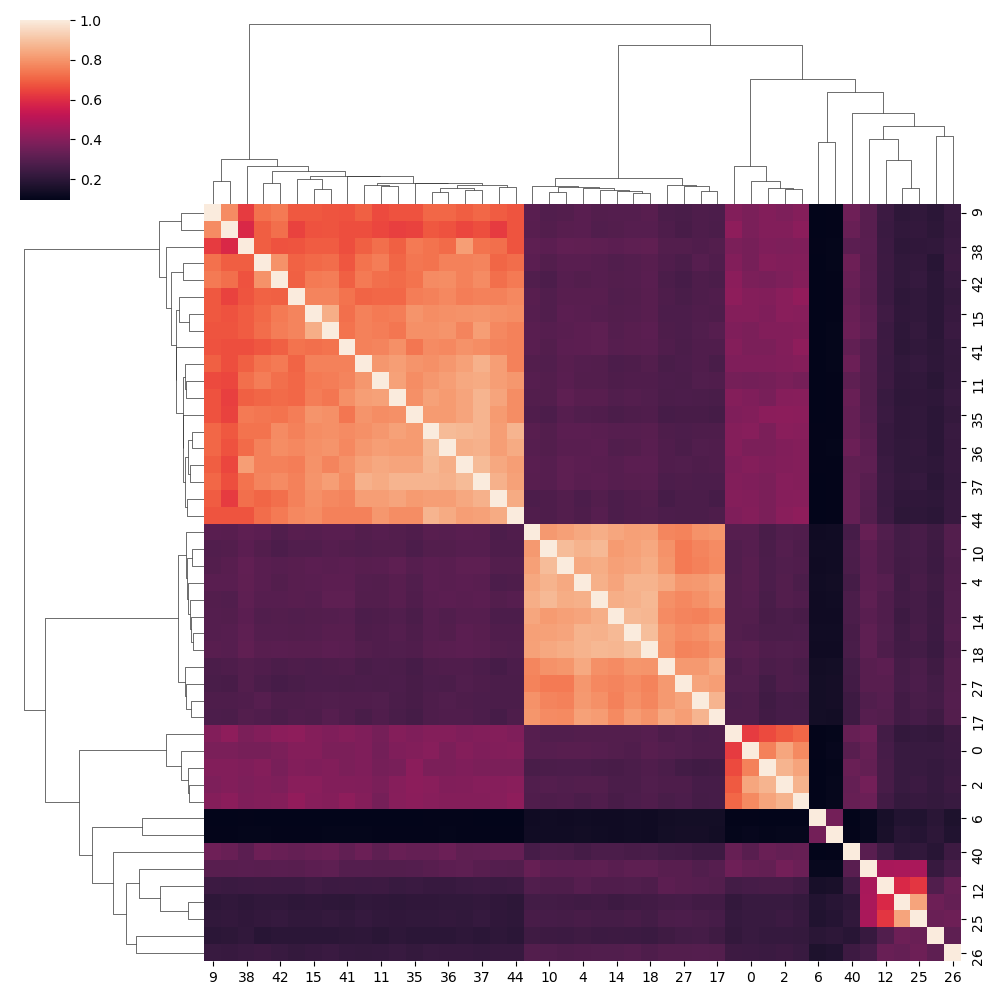

In [551]:
plt.close()
sns.clustermap(alignment_matrix_local)
plt.show()

In [480]:
name_i = reference_df.iloc[0]['cluster_id']+'_'+format(reference_df.iloc[0]['sequence_id'])
name_j = reference_df.iloc[2]['cluster_id']+'_'+format(reference_df.iloc[2]['sequence_id'])
colorprint(align_dict[name_i+'_'+name_j][0].seqA, 'blue')
colorprint(align_dict[name_i+'_'+name_j][0].seqB, 'red')
print(align_dict[name_i+'_'+name_j][0].score/max(len([reference_df.iloc[0]['sequence']]), len(reference_df.iloc[2]['sequence'])))

---MV-LSE-GEWQLVLH-VWA-KVEADVAGHGQDI--LIRLFKS--HPETLEKFDR-FKHLKTEA-EMKASEDLKKHGV-TVLTALGA-ILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISE-AIIHVLH-SR-HPGDFGADAQGAMNKALELFRK-DIAAKYKELGY-QGGSGHHHHHH
GSHM-GLS-DGEWQLVL-NVW-GKVEADVAGHGQ--EVLIRLF--TGHPETLEKFD-KFKHLKTE-DEMKASEDLKKHG-NTVLTALG-GILKKKGHHEAELKPLAQSHATKHKIPIKYLEFIS-DAIIHVL-QS-KHPGDFGADAQGAMNKALELFR-NDIAAKYKELG-FQ---G------
0.8726114649681529


NameError: name 'alignment_matrix_global' is not defined

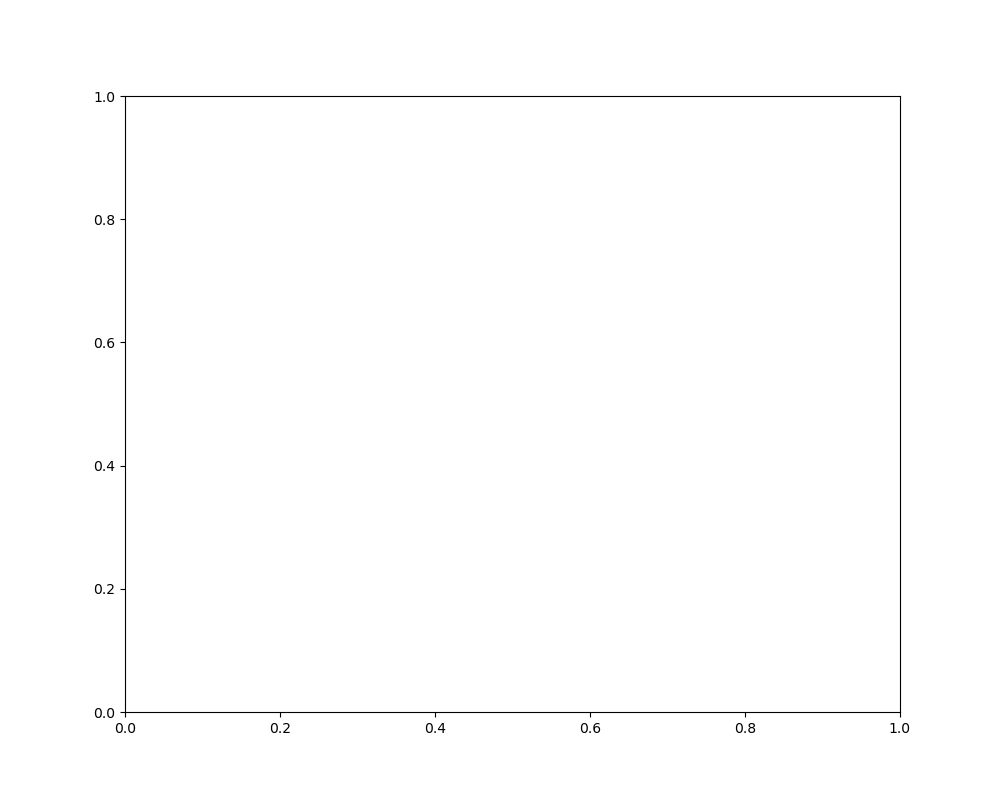

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram
plt.close()
fig, ax = plt.subplots(figsize = (10, 8))
Z = linkage(alignment_matrix_global, 'complete')

plt.title('Hierarchical Clustering Dendrogram')

# Plot axis labels
plt.xlabel('sequence index')
plt.ylabel('distance')

# Make the dendrogram
dendrogram(Z, leaf_rotation=90)
plt.xticks(fontsize=8)
# Show the graph
plt.show()

In [601]:
reference_df.iloc[17]

seq_len (aa)                                                  235
seq_id                                          sequence_312... *
identity (%)                                            reference
cluster_id                                             Cluster 17
sequence_id                                                   312
sequence        MAGFPLLLTLLTHCAGSWAQSVLTQPPSASGTPGQSVNISCSGSSS...
Name: 17, dtype: object

In [553]:
name_i = reference_df.iloc[6]['cluster_id']+'_'+format(reference_df.iloc[6]['sequence_id'])
name_j = reference_df.iloc[17]['cluster_id']+'_'+format(reference_df.iloc[17]['sequence_id'])
print(name_i, name_j)
colorprint(align_dict_local[name_i+'_'+name_j][6].seqA, 'blue')
colorprint(align_dict_local[name_i+'_'+name_j][6].seqB, 'red')

print(align_dict_local[name_i+'_'+name_j][6].score/max(len([reference_df.iloc[6]['sequence']]), len(reference_df.iloc[17]['sequence'])))

Cluster 6_332 Cluster 17_312
M--FVF-LVLLP-LVSSQCVNLTTRTQLPP--AYTNSFTRGVYYPDKVFRS---SVLHSTQDLFLPFF-SNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWME-SEFRVY-SSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPL-VDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFL-LKYNEN-GTITDAVDCALDPLSETKCTLKSFTVEKG-IYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRI-SNC-VA-DYSVLYNSAS-FSTFKCYGVSPTKLN-DLCFTNVY-ADSFV--IR-G----DEVRQIAPGQTGKIADYNYKLPDDFTGCVIA-WNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPV-AIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDI-PIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSV---AYSNNSI-AIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYG-S-FCTQLNRALT--GIAVEQDKNTQEVFAQVKQIYKTPPI-K-DFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNS

In [552]:
name_i = reference_df.iloc[6]['cluster_id']+'_'+format(reference_df.iloc[6]['sequence_id'])
name_j = reference_df.iloc[17]['cluster_id']+'_'+format(reference_df.iloc[17]['sequence_id'])
print(name_i, name_j)
colorprint(align_dict_global[name_i+'_'+name_j][6].seqA, 'blue')
colorprint(align_dict_global[name_i+'_'+name_j][6].seqB, 'red')

print(align_dict_global[name_i+'_'+name_j][6].score/max(len([reference_df.iloc[6]['sequence']]), len(reference_df.iloc[17]['sequence'])))

Cluster 6_332 Cluster 17_312
M--FVF-LVLLP-LVSSQCVNLTTRTQLPP--AYTNSFTRGVYYPDKVFRS---SVLHSTQDLFLPFF-SNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWME-SEFRVY-SSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPL-VDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFL-LKYNEN-GTITDAVDCALDPLSETKCTLKSFTVEKG-IYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRI-SNC-VA-DYSVLYNSAS-FSTFKCYGVSPTKLN-DLCFTNVY-ADSFV--IR-G----DEVRQIAPGQTGKIADYNYKLPDDFTGCVIA-WNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPV-AIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDI-PIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSV---AYSNNSI-AIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYG-S-FCTQLNRALT--GIAVEQDKNTQEVFAQVKQIYKTPPI-K-DFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNS

In [516]:
colorprint(reference_df.iloc[6]['sequence'], 'blue')
colorprint(reference_df.iloc[17]['sequence'], 'red')

MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGR

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogram(icoord, dcoord, figsize, polar=False):
    if polar:
        dcoord = -np.log(dcoord+1)
        # avoid a wedge over the radial labels
        gap = 0.1
        imax = icoord.max()
        imin = icoord.min()
        icoord = ((icoord - imin)/(imax - imin)*(1-gap) + gap/2)*2*np.pi
    with plt.style.context("seaborn-white"):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, polar=polar)
        for xs, ys in zip(icoord, dcoord):
            if polar:
                xs = smoothsegment(xs)
                ys = smoothsegment(ys)
            ax.plot(xs, ys, color="black")
        ax.set_title(f"Polar= {polar}", fontsize=15)
        if polar:
            ax.spines['polar'].set_visible(False)
            ax.set_rlabel_position(0)
            Nxticks = 10
            xticks = np.linspace(gap/2, 1-gap/2, Nxticks)
            ax.set_xticks(xticks*np.pi*2)
            ax.set_xticklabels(np.round(np.linspace(imin, imax, Nxticks)).astype(int))

def smoothsegment(seg, Nsmooth=100):
    return np.concatenate([[seg[0]], np.linspace(seg[1], seg[2], Nsmooth), [seg[3]]])

# Generate example data
np.random.seed(0)
X = np.random.rand(10, 2)  # 10 data points in 2 dimensions

# Perform hierarchical clustering
Z = linkage(alignment_matrix, 'single')
# print(Z)

# Compute dendrogram coordinates
icoord = np.arange(1, len(Z)+1)
dcoord = Z[:, 2]

icoord_, dcoord_ = cartesian_to_polar(icoord, dcoord)
print(icoord)
print(dcoord)
# # Plot the dendrogram
# icoord, dcoord = dendrogram(Z, no_plot=True)

# # Call the custom plot_dendrogram function
# plot_dendrogram(icoord, dcoord, figsize=(8, 3), polar=False)

# # Convert linkage matrix to polar coordinates
# icoord_polar = ((icoord - icoord.min()) / (icoord.max() - icoord.min())) * 2 * np.pi
# dcoord_polar = dcoord

# # Plot the polar dendrogram
# plot_dendrogram(icoord_polar, dcoord_polar, figsize=(5, 5), polar=True)

plt.show()


NameError: name 'alignment_matrix' is not defined

In [531]:
icoord, dcoord = np.meshgrid(np.r_[1:10], np.r_[1:4])

# # Plot the cartesian version
plot_dendrogram(icoord, dcoord, figsize=(8, 3), polar=False)

# # Plot the polar version
plot_dendrogram(icoord, dcoord, figsize=(5, 5), polar=True)

[[1 2 3 4 5 6 7 8 9]
 [1 2 3 4 5 6 7 8 9]
 [1 2 3 4 5 6 7 8 9]] [[1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3 3]]


<ipython-input-525-d38dc641bdb5>:2: UserWarning: Trying to create polar plot on an axis that does not have a polar projection.
  plt.polar(icoord.T, dcoord.T)
<ipython-input-525-d38dc641bdb5>:2: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  plt.polar(icoord.T, dcoord.T)
<ipython-input-525-d38dc641bdb5>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.polar(icoord.T, dcoord.T)


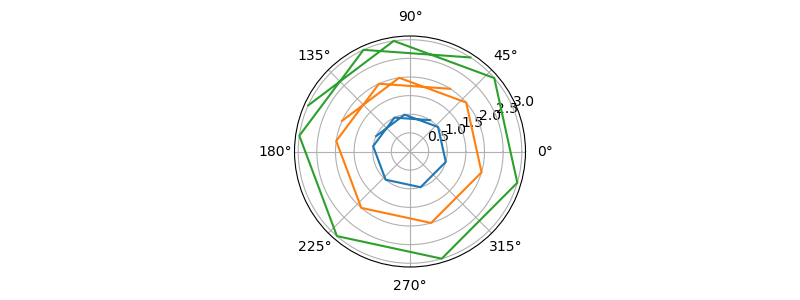

In [525]:
plt.close()
plt.polar(icoord.T, dcoord.T)
plt.show()

<ipython-input-526-7940164a9a3c>:3: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  plt.polar(2 * np.pi * nic, -dcoord.T)


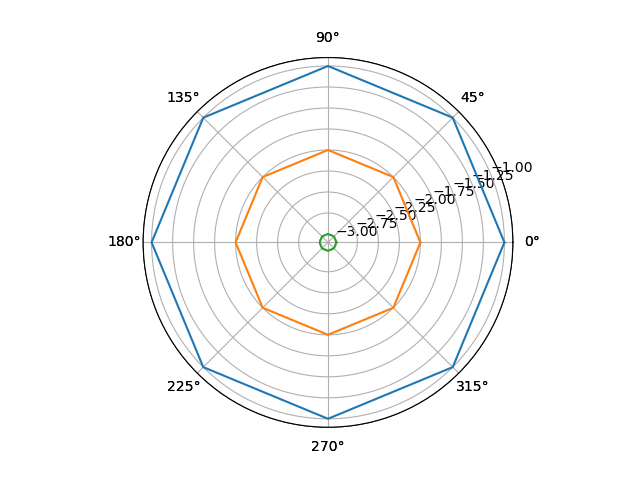

In [526]:
plt.close()
nic = (icoord.T - icoord.min()) / (icoord.max() - icoord.min())
plt.polar(2 * np.pi * nic, -dcoord.T)
plt.show()

<ipython-input-527-b91f09725b77>:4: UserWarning: Trying to create polar plot on an axis that does not have a polar projection.
  plt.polar(2 * np.pi * ico, -np.log(dcoord.T), 'b')
<ipython-input-527-b91f09725b77>:4: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  plt.polar(2 * np.pi * ico, -np.log(dcoord.T), 'b')


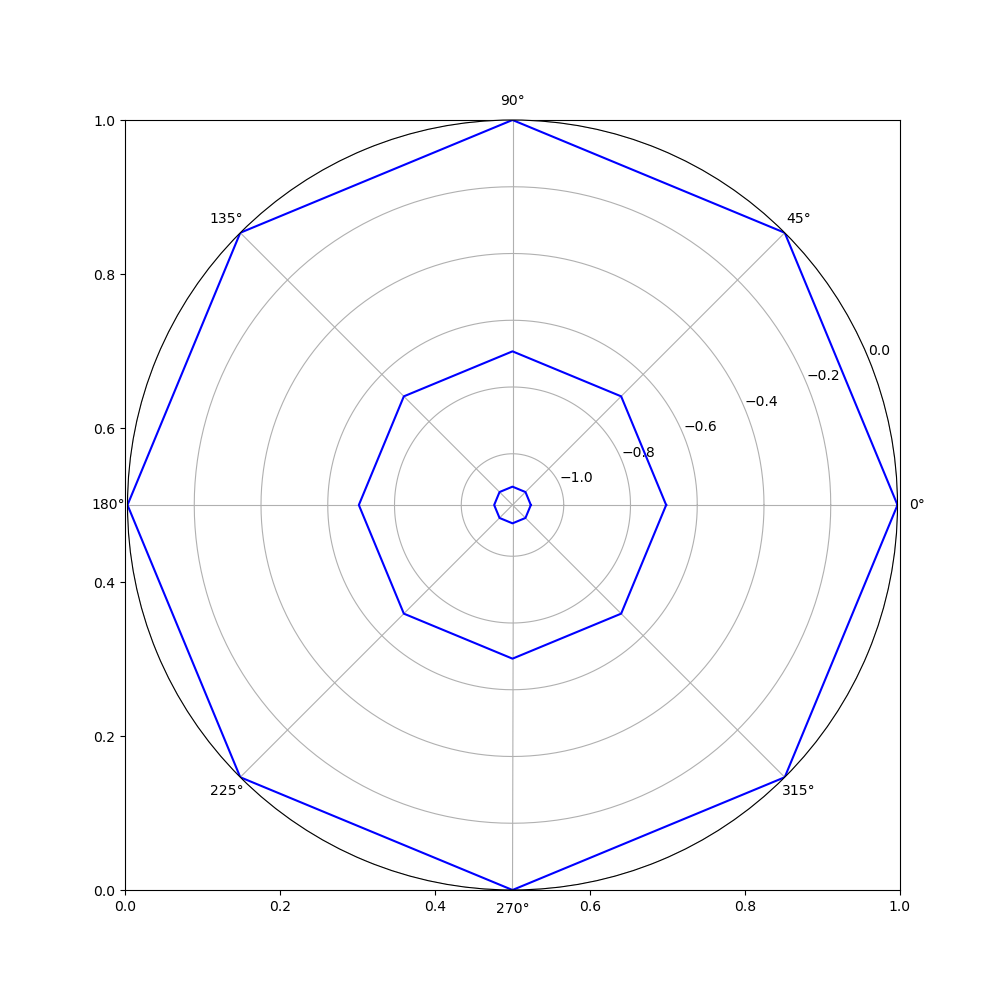

In [527]:
plt.close()
plt.subplots(figsize=(10, 10))
ico = (icoord.T - icoord.min()) / (icoord.max() - icoord.min())
plt.polar(2 * np.pi * ico, -np.log(dcoord.T), 'b')

In [13]:
muscle_msa_ref = pd.read_csv(input_dir+'MUSCLE\\output2_ref_seq\\muscle-I20240329-191032-0822-93888983-p1m-pim.txt', skiprows=4, delimiter='\t')
print(muscle_msa_ref)

                                                    #
0        1: sequence_316  100.00   10.07   10.79  ...
1        2: sequence_41    10.07  100.00   74.39  ...
2        3: sequence_407   10.79   74.39  100.00  ...
3        4: sequence_141   10.79   72.57   81.89  ...
4        5: sequence_210   12.84   69.40   89.07  ...
5        6: sequence_232   13.70   10.48    9.09  ...
6        7: sequence_304   10.49    8.64    7.82  ...
7        8: sequence_390   13.85   21.53   19.44  ...
8        9: sequence_3     13.08   22.22   22.92  ...
9       10: sequence_70    12.21   20.69   19.31  ...
10      11: sequence_384   13.85   19.44   18.06  ...
11      12: sequence_10    11.54   18.06   17.36  ...
12      13: sequence_340   11.54   20.14   18.75  ...
13      14: sequence_13    10.00   20.83   20.83  ...
14      15: sequence_285   12.31   22.92   22.92  ...
15      16: sequence_278   12.31   16.67   15.28  ...
16      17: sequence_15    13.18   18.18   16.78  ...
17      18: sequence_245   1

In [14]:
row_ = {}
for x in muscle_msa_ref.index:
    filtered_row = [item for item in muscle_msa_ref.iloc[x].values[0].split(':')[1].split(' ') if item != '']
    filtered_row_num = [float(x) for x in filtered_row[1:]]
#     print(filtered_row_num)
    row_.update({filtered_row[0]: filtered_row_num})
#     break

In [15]:
muscle_df = pd.DataFrame(row_).T
muscle_df.columns = muscle_df.index
muscle_df

sequence_316  sequence_41  sequence_407  sequence_141  \
sequence_316        100.00        10.07         10.79         10.79   
sequence_41          10.07       100.00         74.39         72.57   
sequence_407         10.79        74.39        100.00         81.89   
sequence_141         10.79        72.57         81.89        100.00   
sequence_210         12.84        69.40         89.07         89.07   
sequence_232         13.70        10.48          9.09          9.09   
sequence_304         10.49         8.64          7.82          7.82   
sequence_390         13.85        21.53         19.44         18.75   
sequence_3           13.08        22.22         22.92         22.22   
sequence_70          12.21        20.69         19.31         18.62   
sequence_384         13.85        19.44         18.06         18.06   
sequence_10          11.54        18.06         17.36         17.36   
sequence_340         11.54        20.14         18.75         17.36   
sequence_13          10.00        20.83         20.83         20.14   
sequence_285         12.31        22.92         22.92         22.22   
sequence_278         12.31        16.67         15.28         15.28   
sequence_15          13.18        18.18         16.78         15.38   
sequence_245         13.08        18.75         18.06         16.67   
sequence_214         10.77        18.06         17.36         15.97   
sequence_35          10.77        20.83         19.44         18.75   
sequence_289         13.08        17.36         16.67         15.28   
sequence_267         15.50        18.18         18.18         17.48   
sequence_108         13.85        18.75         17.36         16.67   
sequence_132         11.54        18.06         17.36         16.67   
sequence_26          11.45        17.93         17.24         16.55   
sequence_173         10.77        20.14         19.44         18.06   
sequence_274          8.40        13.25         14.57         13.91   
sequence_180          7.58        12.42         15.53         14.91   
sequence_20          10.69        13.91         17.22         16.56   
sequence_211          9.92        11.92         15.23         14.57   
sequence_17          10.37        12.26         16.13         15.48   
sequence_332         13.70         6.62          6.93          6.56   
sequence_276          9.66        11.20          9.88          8.77   
sequence_230          4.62        14.37         14.94         15.52   
sequence_72           4.55        12.57         13.14         13.71   
sequence_345          4.58        13.14         12.57         13.14   
sequence_92           3.85        13.79         12.64         13.22   
sequence_349          4.51        13.71         13.14         13.71   
sequence_44           4.58        11.49         12.07         12.64   
sequence_185          3.85        13.22         12.64         13.22   
sequence_312          5.34        11.40         12.44         12.95   
sequence_115          4.58        12.44         12.44         12.94   
sequence_120          5.34        11.33         12.32         12.81   
sequence_287          3.82        11.92         12.44         12.95   
sequence_54           3.79        13.71         14.29         14.86   

              sequence_210  sequence_232  sequence_304  sequence_390  \
sequence_316         12.84         13.70         10.49         13.85   
sequence_41          69.40         10.48          8.64         21.53   
sequence_407         89.07          9.09          7.82         19.44   
sequence_141         89.07          9.09          7.82         18.75   
sequence_210        100.00          8.72          7.91         19.61   
sequence_232          8.72        100.00          9.61         17.81   
sequence_304          7.91          9.61        100.00         18.62   
sequence_390         19.61         17.81         18.62        100.00   
sequence_3           23.53         18.49         20.69         76.03   
sequence_70          21.36 

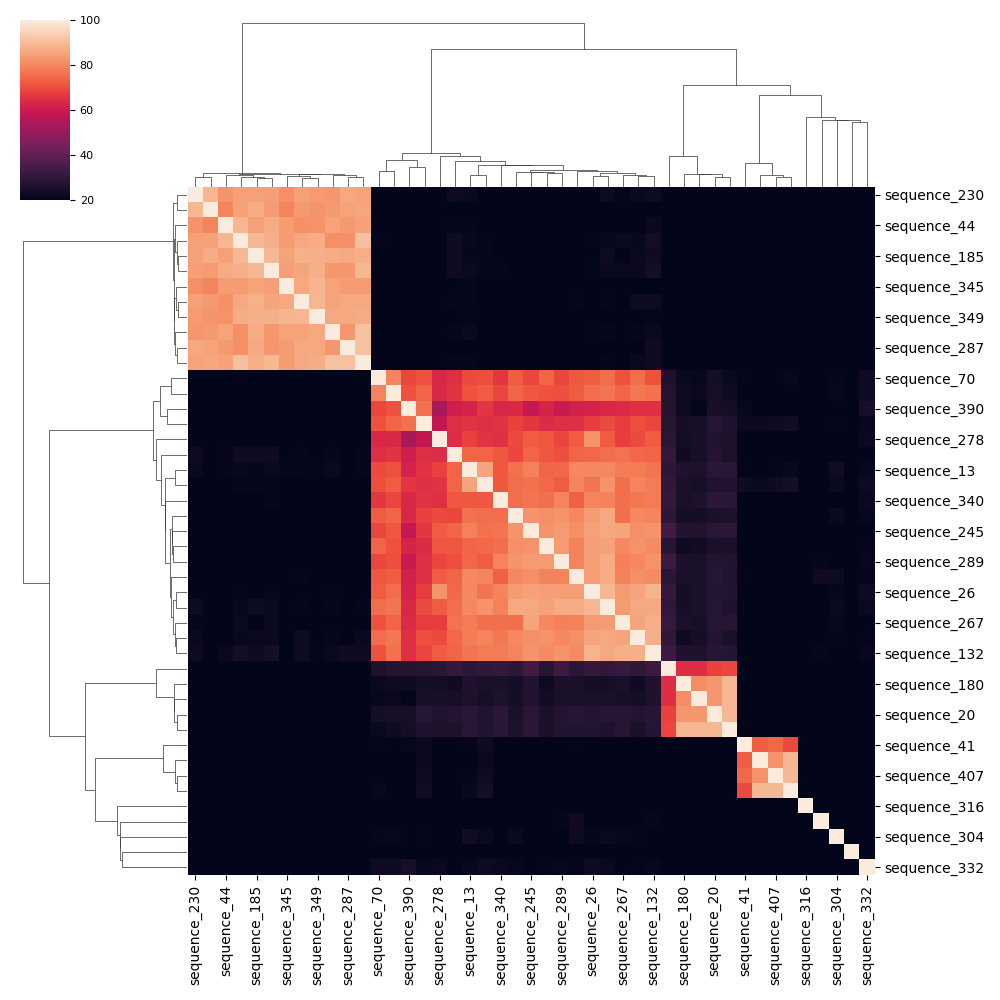

In [595]:
plt.close('all')
sns.clustermap(muscle_df, vmin=20, vmax=100)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [16]:
muscle_msa_all = pd.read_csv(input_dir+'MUSCLE\\output1_all_seq\\muscle-I20240328-194746-0627-19218052-p1m-pim.txt', skiprows=4, delimiter='\t')
print(muscle_msa_all)
row_2 = {}
for x in muscle_msa_all.index:
    filtered_row = [item for item in muscle_msa_all.iloc[x].values[0].split(':')[1].split(' ') if item != '']
    filtered_row_2num = [float(x) for x in filtered_row[1:]]
#     print(filtered_row_2num)
    row_2.update({filtered_row[0]: filtered_row_2num})
#     break

muscle_df_all = pd.DataFrame(row_2).T
muscle_df_all.columns = muscle_df_all.index
muscle_df_all

                                                     #
0         1: sequence_316  100.00    8.96    8.28  ...
1         2: sequence_232    8.96  100.00    8.64  ...
2         3: sequence_304    8.28    8.64  100.00  ...
3         4: sequence_174   12.14    5.86    8.58  ...
4         5: sequence_189   12.14    5.86    8.58  ...
..                                                 ...
406     407: sequence_110   10.45   14.21   16.59  ...
407     408: sequence_99    10.45   14.66   16.50  ...
408     409: sequence_324   10.45   14.66   16.50  ...
409     410: sequence_345   11.19   15.18   16.02  ...
410     411: sequence_402   11.94   15.18   16.02  ...

[411 rows x 1 columns]


sequence_316  sequence_232  sequence_304  sequence_174  \
sequence_316        100.00          8.96          8.28         12.14   
sequence_232          8.96        100.00          8.64          5.86   
sequence_304          8.28          8.64        100.00          8.58   
sequence_174         12.14          5.86          8.58        100.00   
sequence_189         12.14          5.86          8.58         98.97   
...                    ...           ...           ...           ...   
sequence_110         10.45         14.21         16.59         10.11   
sequence_99          10.45         14.66         16.50         10.16   
sequence_324         10.45         14.66         16.50         10.16   
sequence_345         11.19         15.18         16.02          9.63   
sequence_402         11.94         15.18         16.02         10.16   

              sequence_189  sequence_31  sequence_41  sequence_66  \
sequence_316         12.14        12.14        12.14        10.94   
sequence_232          5.86         5.86         5.86         6.41   
sequence_304          8.58         8.58         8.58         9.82   
sequence_174         98.97        99.31        99.30        69.78   
sequence_189        100.00        99.65        99.65        70.88   
...                    ...          ...          ...          ...   
sequence_110         10.64        10.11        10.27         9.94   
sequence_99          10.70        10.16        10.33         9.38   
sequence_324         10.70        10.16        10.33        10.00   
sequence_345         10.16         9.63         9.78        10.62   
sequence_402         10.70        10.16        10.33        11.25   

              sequence_109  sequence_40  ...  sequence_349  sequence_320  \
sequence_316         10.94        10.94  ...         10.14         11.19   
sequence_232          5.77         6.58  ...         14.14         14.66   
sequence_304          9.82        10.06  ...         16.19         16.50   
sequence_174         69.23        76.83  ...         10.47         10.16   
sequence_189         70.33        78.05  ...         10.99         10.70   
...                    ...          ...  ...           ...           ...   
sequence_110          9.94        10.26  ...         95.37         97.22   
sequence_99           9.38         9.62  ...         95.37         94.91   
sequence_324         10.00        10.26  ...         96.77         96.77   
sequence_345         10.00        10.26  ...         89.40         91.71   
sequence_402         10.62        10.90  ...         89.40         92.63   

              sequence_224  sequence_313  sequence_373  sequence_110  \
sequence_316         10.45         10.45         10.45         10.45   
sequence_232         14.74         14.66         14.74         14.21   
sequence_304         16.59         16.50         16.59         16.59   
sequence_174         10.22         10.16          9.95         10.11   
sequence_189         10.75         10.70         10.47         10.64   
...                    ...           ...           ...           ...   
sequence_110         95.35         96.30         95.85        100.00   
sequence_99          94.88         95.37         96.28         96.28   
sequence_324         97.22         98.16         98.15         98.15   
sequence_345         89.81         89.40         88.43         90.28   
sequence_402         90.28         90.78         89.81         91.20   

              sequence_99  sequence_324  sequence_345  sequence_402  
sequence_316        10.45         10.45         11.19         11.94  
sequence_232        14.66         14.66         15.18         15.18  
sequence_304        16.50         16.50         16.02         16.02  
sequence_174        10.16         10.16          9.63         10.16  
sequence_189        10.70         10.70         10.16         10.70  
...                   ...           ...           ...           ...  
sequence_110        96.28         98.15         90.2

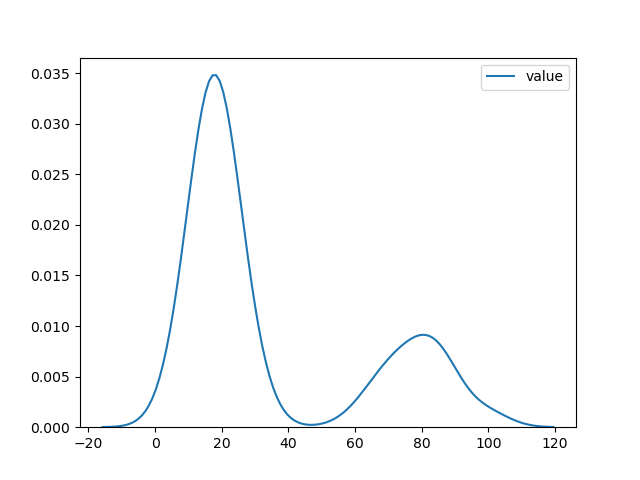

In [17]:
plt.close()
p = pd.melt(muscle_df)
sns.kdeplot(p['value'])
plt.show()

In [18]:

indices = ['sequence_'+format(i) for i in range(1, 412)]
# # indices
sorted_muscle_df =  muscle_df_all.loc[indices, indices]
sorted_muscle_df

sequence_1  sequence_2  sequence_3  sequence_4  sequence_5  \
sequence_1        100.00       13.25       24.83       13.10       25.52   
sequence_2         13.25      100.00       17.93       10.26       20.00   
sequence_3         24.83       17.93      100.00       15.17       66.44   
sequence_4         13.10       10.26       15.17      100.00       16.55   
sequence_5         25.52       20.00       66.44       16.55      100.00   
...                  ...         ...         ...         ...         ...   
sequence_407       13.16       12.77       15.75       91.41       17.12   
sequence_408       11.18       23.04       14.48        9.26       15.17   
sequence_409       84.31       13.16       23.97       15.75       24.66   
sequence_410       25.00       20.14       68.28       14.58       82.07   
sequence_411       83.66       13.16       24.66       15.75       25.34   

              sequence_6  sequence_7  sequence_8  sequence_9  sequence_10  \
sequence_1         88.24       84.31       12.86       84.31        24.83   
sequence_2         12.58       13.16       10.27       13.16        20.00   
sequence_3         26.21       23.97       15.11       23.97        65.07   
sequence_4         14.48       15.75       95.42       15.07        15.86   
sequence_5         26.21       24.66       15.83       24.66        73.29   
...                  ...         ...         ...         ...          ...   
sequence_407       13.82       15.03       97.39       14.38        14.38   
sequence_408        9.87       11.76       10.53       11.76        15.86   
sequence_409       84.31       99.35       15.00       97.40        22.60   
sequence_410       25.69       23.45       12.95       24.14        68.97   
sequence_411       84.31       98.70       15.00       97.40        23.29   

              ...  sequence_402  sequence_403  sequence_404  sequence_405  \
sequence_1    ...         10.00         11.33         25.52         83.66   
sequence_2    ...         82.87         84.72         19.31         13.25   
sequence_3    ...         17.93         17.93         66.44         22.76   
sequence_4    ...         11.61          9.03         16.55         15.17   
sequence_5    ...         19.31         20.00         98.63         22.76   
...           ...           ...           ...           ...           ...   
sequence_407  ...         13.37         11.23         17.12         14.47   
sequence_408  ...         24.42         25.93         15.86         11.84   
sequence_409  ...         10.60         11.92         24.66         96.73   
sequence_410  ...         20.14         20.14         82.07         22.92   
sequence_411  ...         10.60         11.92         25.34         96.73   

              sequence_406  sequence_407  sequence_408  sequence_409  \
sequence_1           12.41         13.16         11.18         84.31   
sequence_2           10.06         12.77         23.04         13.16   
sequence_3           14.48         15.75         14.48         23.97   
sequence_4           95.71         91.41          9.26         15.75   
sequence_5           15.86         17.12         15.17         24.66   
...                    ...           ...           ...           ...   
sequence_407         93.37        100.00          9.97         15.03   
sequence_408          9.70          9.97        100.00         11.76   
sequence_409         14.38         15.03         11.76        100.00   
sequence_410         13.89         15.17         15.28         23.45   
sequence_411         14.38         15.03         11.11         98.70   

              sequence_410  sequence_411  
sequence_1           25.00         83.66  
sequence_2           20.14         13.16  
sequence_3           68.28         24.66  
sequence_4           14.58         15.75  
sequence_5           82.07         25.34  
...                    ...           ...  
sequence_407         15.17         15.03  
sequence_408         15.28         11.11  

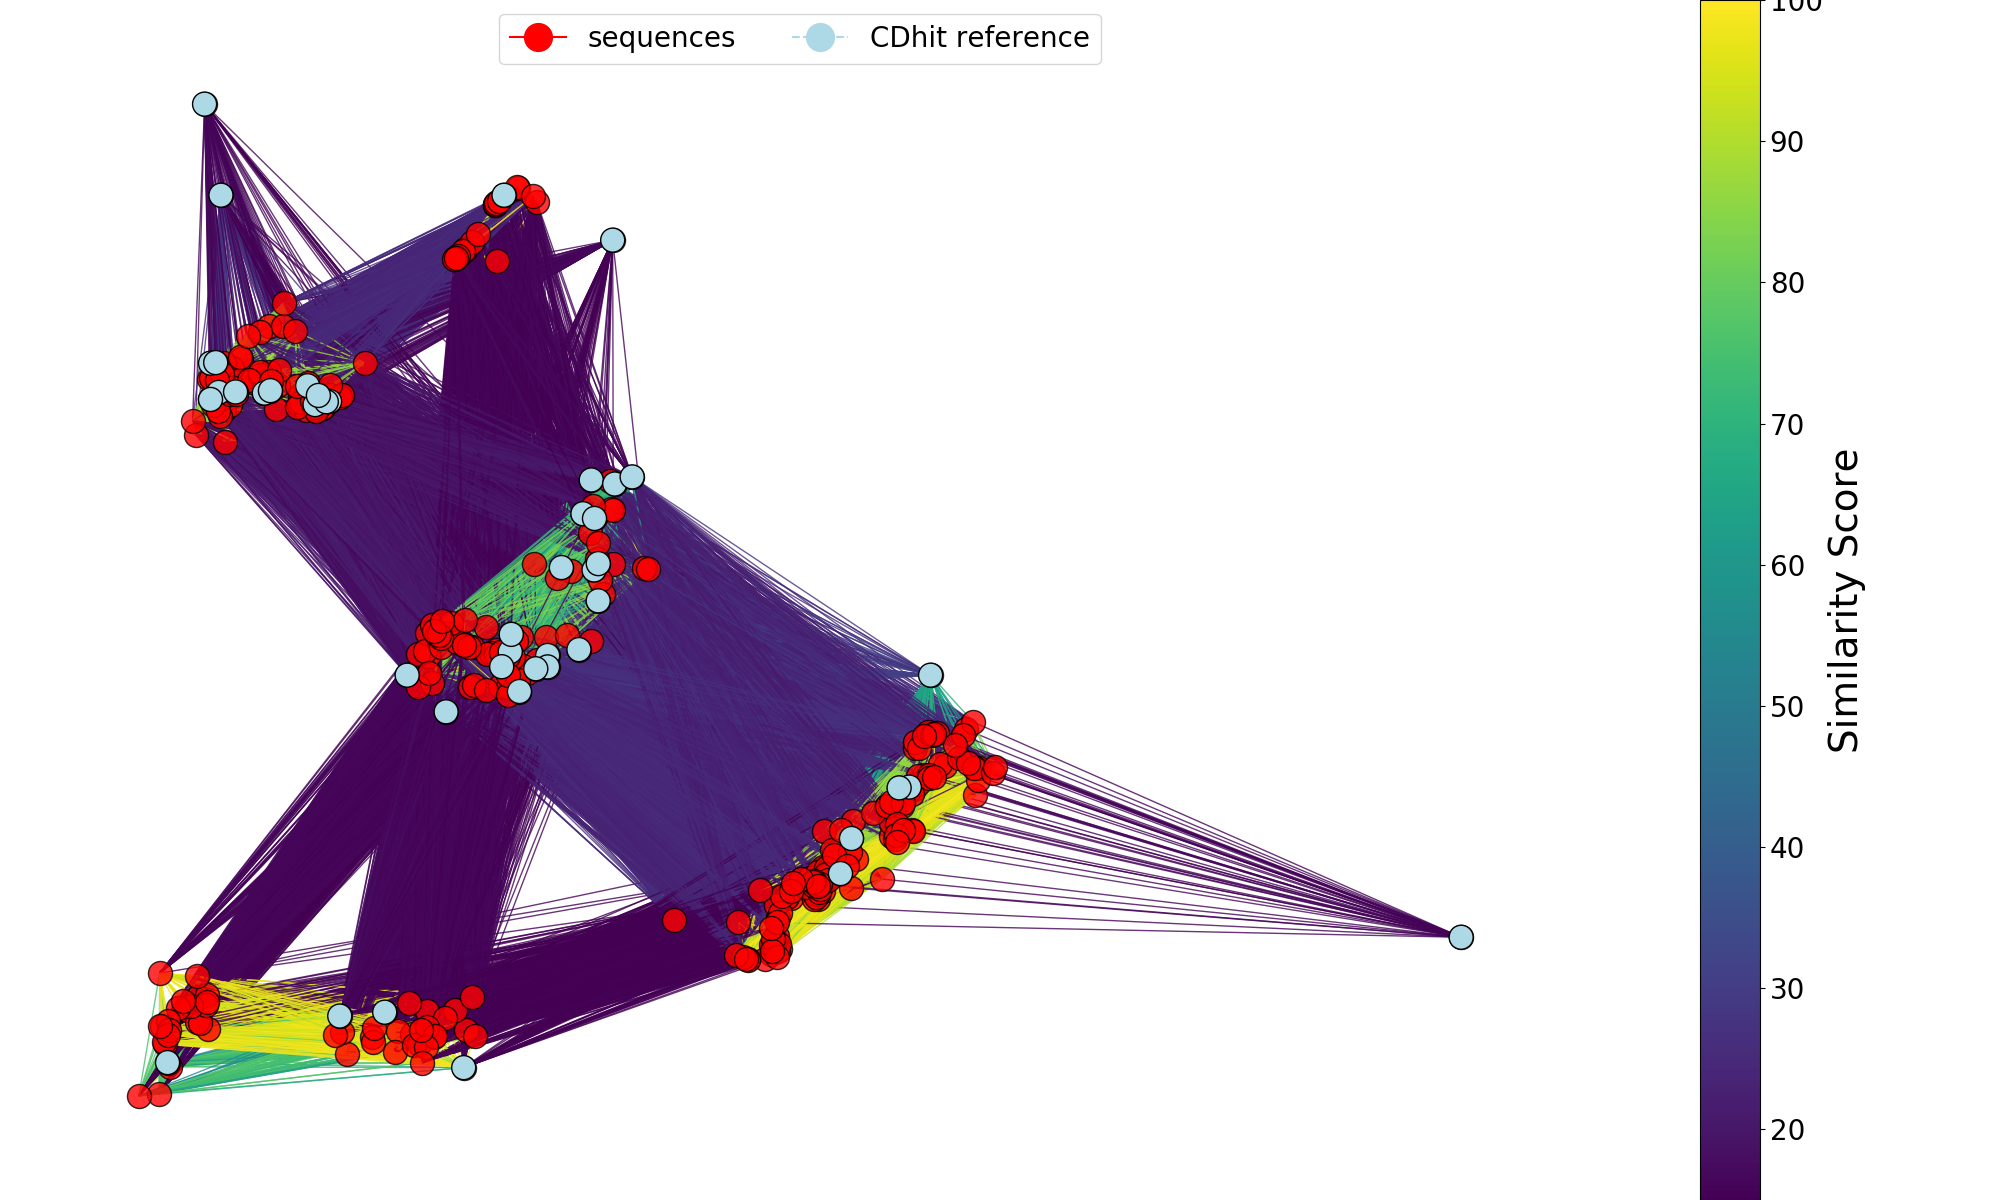

In [19]:
import networkx as nx
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

plt.close('all')

# sorted_muscle_df = sorted_muscle_df.apply(lambda x)
# Create a graph

# Draw the network
plt.figure(figsize=(20, 12))  # Adjust width and height as needed
G = nx.Graph()
# threshold = 15
# Add nodes to the graph

# # Define minimum and maximum threshold values
min_threshold = 15
max_threshold = 100

num_proteins = sorted_muscle_df.shape[0]
for i in range(num_proteins):
    G.add_node(i)

# Add edges to the graph based on similarity scores
for i in range(num_proteins):
    for j in range(i + 1, num_proteins):
        similarity_score = sorted_muscle_df.iloc[i, j]
        if min_threshold <= similarity_score <= max_threshold:  # Only add edges within the range
#             print(i, j, similarity_score)
            G.add_edge(i, j, weight=similarity_score)
#         if similarity_score > threshold:  # Set your threshold here
#             G.add_edge(i, j, weight=similarity_score)
# # Draw the network
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm

# Get edge weights
edge_weights = nx.get_edge_attributes(G, 'weight').values()

# Define colormap and normalize it
cmap = plt.cm.viridis  # Choose your colormap
norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))

# # Draw edges with weights and colorbar
nx.draw(G, pos, with_labels=False, node_color='red', node_size=300,
        edge_color=edge_weights, width=1, edge_cmap=cmap, edge_vmin=min(edge_weights), edge_vmax=max(edge_weights), alpha=0.8, edgecolors='black')
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Similarity Score', fontsize=28)

# These nodes are by CDhit reference sequences
specific_nodes = {x-1: 'lightblue' for x in sorted([int(x.split('_')[1]) for x in muscle_df.index])}

# # Draw specific nodes with their specified colors
nx.draw_networkx_nodes(G, pos, nodelist=specific_nodes.keys(), node_color=list(specific_nodes.values()), node_size=300, edgecolors='black')


# Create custom legend handles
custom_legend = [Line2D([0], [0], color='red', linestyle='-', marker='o', markersize=20),
                 Line2D([0], [0], color='lightblue', linestyle='--', marker='o', markersize=20)]

# Create custom legend labels
legend_labels = ['sequences', 'CDhit reference']
# Add legend with custom handles and labels

plt.legend(handles= custom_legend, labels= legend_labels, loc='upper center', fontsize=20, ncol=2)
cbar.ax.tick_params(labelsize=20)
plt.title("Protein Similarity Network")
plt.show()

In [74]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

plt.close('all')

distance_matrix_sorted = {}

for i in range(sorted_muscle_df.shape[0]):
    for j in range(i + 1, sorted_muscle_df.shape[0]):
#         print(i, j)
#         print(f'sequence_{i+1}', f'sequence_{j+1}')
#         print(sorted_muscle_df.loc[f'sequence_{i+1}'][f'sequence_{j+1}'])
        distance_score = 1 - (sorted_muscle_df.loc[f'sequence_{i+1}'][f'sequence_{j+1}'])*0.01
        distance_matrix_sorted.update({f'sequence_{i+1}_sequence_{j+1}': distance_score})
#     break
# print(pd.Series(distance_matrix_sorted))
# # distance_matrix_sorted
distance_mat = pd.Series(distance_matrix_sorted)
distance_mat.columns = ['distance']
print(distance_mat)


sequence_1_sequence_2        0.8675
sequence_1_sequence_3        0.7517
sequence_1_sequence_4        0.8690
sequence_1_sequence_5        0.7448
sequence_1_sequence_6        0.1176
                              ...  
sequence_408_sequence_410    0.8472
sequence_408_sequence_411    0.8889
sequence_409_sequence_410    0.7655
sequence_409_sequence_411    0.0130
sequence_410_sequence_411    0.7586
Length: 84255, dtype: float64


In [89]:
symm_dist = sorted_muscle_df # .applymap(lambda x: 1 - (x*0.01))
symm_dist

sequence_1  sequence_2  sequence_3  sequence_4  sequence_5  \
sequence_1        100.00       13.25       24.83       13.10       25.52   
sequence_2         13.25      100.00       17.93       10.26       20.00   
sequence_3         24.83       17.93      100.00       15.17       66.44   
sequence_4         13.10       10.26       15.17      100.00       16.55   
sequence_5         25.52       20.00       66.44       16.55      100.00   
...                  ...         ...         ...         ...         ...   
sequence_407       13.16       12.77       15.75       91.41       17.12   
sequence_408       11.18       23.04       14.48        9.26       15.17   
sequence_409       84.31       13.16       23.97       15.75       24.66   
sequence_410       25.00       20.14       68.28       14.58       82.07   
sequence_411       83.66       13.16       24.66       15.75       25.34   

              sequence_6  sequence_7  sequence_8  sequence_9  sequence_10  \
sequence_1         88.24       84.31       12.86       84.31        24.83   
sequence_2         12.58       13.16       10.27       13.16        20.00   
sequence_3         26.21       23.97       15.11       23.97        65.07   
sequence_4         14.48       15.75       95.42       15.07        15.86   
sequence_5         26.21       24.66       15.83       24.66        73.29   
...                  ...         ...         ...         ...          ...   
sequence_407       13.82       15.03       97.39       14.38        14.38   
sequence_408        9.87       11.76       10.53       11.76        15.86   
sequence_409       84.31       99.35       15.00       97.40        22.60   
sequence_410       25.69       23.45       12.95       24.14        68.97   
sequence_411       84.31       98.70       15.00       97.40        23.29   

              ...  sequence_402  sequence_403  sequence_404  sequence_405  \
sequence_1    ...         10.00         11.33         25.52         83.66   
sequence_2    ...         82.87         84.72         19.31         13.25   
sequence_3    ...         17.93         17.93         66.44         22.76   
sequence_4    ...         11.61          9.03         16.55         15.17   
sequence_5    ...         19.31         20.00         98.63         22.76   
...           ...           ...           ...           ...           ...   
sequence_407  ...         13.37         11.23         17.12         14.47   
sequence_408  ...         24.42         25.93         15.86         11.84   
sequence_409  ...         10.60         11.92         24.66         96.73   
sequence_410  ...         20.14         20.14         82.07         22.92   
sequence_411  ...         10.60         11.92         25.34         96.73   

              sequence_406  sequence_407  sequence_408  sequence_409  \
sequence_1           12.41         13.16         11.18         84.31   
sequence_2           10.06         12.77         23.04         13.16   
sequence_3           14.48         15.75         14.48         23.97   
sequence_4           95.71         91.41          9.26         15.75   
sequence_5           15.86         17.12         15.17         24.66   
...                    ...           ...           ...           ...   
sequence_407         93.37        100.00          9.97         15.03   
sequence_408          9.70          9.97        100.00         11.76   
sequence_409         14.38         15.03         11.76        100.00   
sequence_410         13.89         15.17         15.28         23.45   
sequence_411         14.38         15.03         11.11         98.70   

              sequence_410  sequence_411  
sequence_1           25.00         83.66  
sequence_2           20.14         13.16  
sequence_3           68.28         24.66  
sequence_4           14.58         15.75  
sequence_5           82.07         25.34  
...                    ...           ...  
sequence_407         15.17         15.03  
sequence_408         15.28         11.11  

In [90]:
symm_dist['sequence_411'].loc['sequence_2']

13.16

In [99]:

plt.close('all')

distance_matrix_sorted = {}

for i in range(sorted_muscle_df.shape[0]):
    for j in range(i + 1, sorted_muscle_df.shape[0]):
#         print(i, j)
#         print(f'sequence_{i+1}', f'sequence_{j+1}')
#         print(sorted_muscle_df.loc[f'sequence_{i+1}'][f'sequence_{j+1}'])
#         distance_score = sorted_muscle_df.loc[f'sequence_{i+1}'][f'sequence_{j+1}']
        distance_score = 1 - (sorted_muscle_df.loc[f'sequence_{i+1}'][f'sequence_{j+1}'])*0.01
        distance_matrix_sorted.update({f'sequence_{i+1}_sequence_{j+1}': distance_score})
#     break
# print(pd.Series(distance_matrix_sorted))
# # distance_matrix_sorted
distance_mat = pd.Series(distance_matrix_sorted)
distance_mat.columns = ['distance']
print(distance_mat)


sequence_1_sequence_2        0.8675
sequence_1_sequence_3        0.7517
sequence_1_sequence_4        0.8690
sequence_1_sequence_5        0.7448
sequence_1_sequence_6        0.1176
                              ...  
sequence_408_sequence_410    0.8472
sequence_408_sequence_411    0.8889
sequence_409_sequence_410    0.7655
sequence_409_sequence_411    0.0130
sequence_410_sequence_411    0.7586
Length: 84255, dtype: float64


In [117]:
Y = hierarchy.linkage(distance_mat, method='complete')
print(Y)

[[116.     174.       0.       2.    ]
 [268.     411.       0.       3.    ]
 [ 36.     243.       0.       2.    ]
 ...
 [315.     811.       0.9083  53.    ]
 [815.     817.       0.9145 358.    ]
 [818.     819.       0.9423 411.    ]]


In [93]:
Y.shape

(410, 4)

In [85]:
symm_dist.loc['sequence_232']

sequence_1      0.8609
sequence_2      0.8534
sequence_3      0.8819
sequence_4      0.9404
sequence_5      0.8472
                 ...  
sequence_407    0.9174
sequence_408    0.9029
sequence_409    0.8618
sequence_410    0.8462
sequence_411    0.8618
Name: sequence_232, Length: 411, dtype: float64

In [113]:
# Y[:3]

In [124]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
# import matplotlib.cm as cm
from matplotlib.axes import Axes
import matplotlib
from matplotlib.lines import Line2D

# import seaborn as sns
# sns.set_theme()


colormap_list = [
    "nipy_spectral",
    "terrain",
    "gist_rainbow",
    "CMRmap",
    "coolwarm",
    "gnuplot",
    "gist_stern",
    "brg",
    "rainbow",
]


def radialTreee(
    Z2,
    fontsize=8,
    ax: Axes = None,
    pallete="gist_rainbow",
    addlabels=True,
    sample_classes=None,
    colorlabels=None,
    colorlabels_legend=None,
):

    """
    Drawing a radial dendrogram from a scipy dendrogram output.
    Parameters
    ----------
    Z2 : dictionary
        A dictionary returned by scipy.cluster.hierarchy.dendrogram
    addlabels: bool
        A bool to choose if labels are shown.
    fontsize : float
        A float to specify the font size

    ax : Axes or None:
        Axes in which to draw the plot, otherwise use the currently-active Axes.
    pallete : string

        Matlab colormap name.
    sample_classes : dict
        A dictionary that contains lists of sample subtypes or classes. These classes appear
        as color labels of each leaf. Colormaps are automatically assigned. Not compatible
        with options "colorlabels" and "colorlabels_legend".
        e.g., {"color1":["Class1","Class2","Class1","Class3", ....]}
    colorlabels : dict
        A dictionary to set color labels to leaves. The key is the name of the color label.
        The value is the list of RGB color codes, each corresponds to the color of a leaf.
        e.g., {"color1":[[1,0,0,1], ....]}
    colorlabels_legend : dict
        A nested dictionary to generate the legends of color labels. The key is the name of
        the color label. The value is a dictionary that has two keys "colors" and "labels".
        The value of "colors" is the list of RGB color codes, each corresponds to the class of a leaf.
        e.g., {"color1":{"colors":[[1,0,0,1], ....], "labels":["label1","label2",...]}}

    Returns
    -------
    Raises
    ------
    Notes
    -----
    References
    ----------
    See Also
    --------
    Examples
    --------
    """
    if ax is None:
        ax: Axes = plt.gca()
    linewidth = 0.5
    R = 1
    width = R * 0.1
    space = R * 0.05

    if colorlabels != None:
        offset = (
            width * len(colorlabels) / R + space * (len(colorlabels) - 1) / R + 0.05
        )
        print(offset)
    elif sample_classes != None:
        offset = (
            width * len(sample_classes) / R
            + space * (len(sample_classes) - 1) / R
            + 0.05
        )
        print(offset)
    else:

        offset = 0

    xmax = np.amax(Z2["icoord"])
    xmin = np.amin(Z2["icoord"])
    ymax = np.amax(Z2["dcoord"])
    # print(
    #     f"{xmax=}",
    #     np.amin(Z2["icoord"]),
    #     (xmax - xmin) / (len(Z2["ivl"]) - 1),
    #     (len(Z2["ivl"])),
    # )
    ucolors = sorted(set(Z2["color_list"]))
    # cmap = plt.cm.gist_rainbow(np.linspace(0, 1, len(ucolors)))
    cmp = plt.cm.get_cmap(pallete, len(ucolors))
    # print(cmp)
    if type(cmp) == matplotlib.colors.LinearSegmentedColormap:
        cmap = cmp(np.linspace(0, 1, len(ucolors)))
    else:
        cmap = cmp.colors

    nlabels = 0
    for icoord, dcoord, c in sorted(zip(Z2["icoord"], Z2["dcoord"], Z2["color_list"])):
        # x, y = Z2['icoord'][0], Z2['dcoord'][0]
        _color = cmap[ucolors.index(c)]
        if c == "C0":  # np.abs(_xr1)<0.000000001 and np.abs(_yr1) <0.000000001:
            _color = "black"

        # transforming original x coordinates into relative circumference positions and y into radius
        # the rightmost leaf is going to [1, 0]
        r = R * (1 - np.array(dcoord) / ymax)
        _x = np.cos(
            2 * np.pi * np.array([icoord[0], icoord[2]]) / xmax
        )  # transforming original x coordinates into x circumference positions
        _xr0 = _x[0] * r[0]
        _xr1 = _x[0] * r[1]
        _xr2 = _x[1] * r[2]
        _xr3 = _x[1] * r[3]
        _y = np.sin(
            2 * np.pi * np.array([icoord[0], icoord[2]]) / xmax
        )  # transforming original x coordinates into y circumference positions
        _yr0 = _y[0] * r[0]
        _yr1 = _y[0] * r[1]
        _yr2 = _y[1] * r[2]
        _yr3 = _y[1] * r[3]
        # ax.scatter([_xr0, _xr1, _xr2, _xr3],[_yr0, _yr1, _yr2,_yr3], c="b")

        # if y[0]>0 and y[3]>0:
        # _color="black"
        # plotting radial lines
        ax.plot([_xr0, _xr1], [_yr0, _yr1], c=_color, linewidth=linewidth)
        ax.plot([_xr2, _xr3], [_yr2, _yr3], c=_color, linewidth=linewidth)

        # plotting circular links between nodes
        if _yr1 > 0 and _yr2 > 0:
            link = np.sqrt(r[1] ** 2 - np.linspace(_xr1, _xr2, 100) ** 2)
            ax.plot(np.linspace(_xr1, _xr2, 100), link, c=_color, linewidth=linewidth)
        elif _yr1 < 0 and _yr2 < 0:
            link = -np.sqrt(r[1] ** 2 - np.linspace(_xr1, _xr2, 100) ** 2)

            ax.plot(np.linspace(_xr1, _xr2, 100), link, c=_color, linewidth=linewidth)
        elif _yr1 > 0 and _yr2 < 0:
            _r = r[1]
            if _xr1 < 0 or _xr2 < 0:
                _r = -_r
            link = np.sqrt(r[1] ** 2 - np.linspace(_xr1, _r, 100) ** 2)
            ax.plot(np.linspace(_xr1, _r, 100), link, c=_color, linewidth=linewidth)
            link = -np.sqrt(r[1] ** 2 - np.linspace(_r, _xr2, 100) ** 2)
            ax.plot(np.linspace(_r, _xr2, 100), link, c=_color, linewidth=linewidth)

    label_coords = []
    # determine the coordiante of the labels and their rotation:
    for i, label in enumerate(Z2["ivl"]):
        # scipy (1.x.x) places the leaves in x = 5+i*10 , and we can use this
        # to calulate where to put the labels
        place = (5.0 + i * 10.0) / xmax * 2
        label_coords.append(
            [
                np.cos(place * np.pi) * (1.05 + offset),  # _x
                np.sin(place * np.pi) * (1.05 + offset),  # _y
                place * 180,  # _rot
            ]
        )
    if addlabels == True:
        assert len(Z2["ivl"]) == len(label_coords), (
            f'Internal error, label numbers for Z2 ({len(Z2["ivl"])})'
            f" and for calculated labels ({len(label_coords)}) must be equal!"
        )
        for (_x, _y, _rot), label in zip(label_coords, Z2["ivl"]):
            ax.text(
                _x,
                _y,
                label,
                {"va": "center"},
                rotation_mode="anchor",
                rotation=_rot,
                fontsize=fontsize,
            )

    if colorlabels != None:
        assert len(Z2["ivl"]) == len(label_coords), (
            "Internal error, label numbers "
            + str(len(Z2["ivl"]))
            + " and "
            + str(len(label_coords))
            + " must be equal!"
        )

        j = 0
        outerrad = R * 1.05 + width * len(colorlabels) + space * (len(colorlabels) - 1)

        print(outerrad)
        # sort_index=np.argsort(Z2['icoord'])
        # print(sort_index)
        intervals = []
        for i in range(len(label_coords)):
            _xl, _yl, _rotl = label_coords[i - 1]
            _x, _y, _rot = label_coords[i]
            if i == len(label_coords) - 1:
                _xr, _yr, _rotr = label_coords[0]
            else:
                _xr, _yr, _rotr = label_coords[i + 1]
            d = ((_xr - _xl) ** 2 + (_yr - _yl) ** 2) ** 0.5
            intervals.append(d)
        colorpos = intervals  # np.ones([len(label_coords)])
        labelnames = []
        for labelname, colorlist in colorlabels.items():

            colorlist = np.array(colorlist)[Z2["leaves"]]
            outerrad = outerrad - width * j - space * j
            innerrad = outerrad - width
            patches, texts = ax.pie(
                colorpos,
                colors=colorlist,
                radius=outerrad,
                counterclock=True,
                startangle=label_coords[0][2] * 0.5,
                wedgeprops=dict(
                    width=width,
                    # edgecolor='w', #if this is active the wedges will be more clearly separated
                ),
            )


            labelnames.append(labelname)
            j += 1

        if colorlabels_legend != None:
            for i, labelname in enumerate(labelnames):
                print(colorlabels_legend[labelname]["colors"])
                colorlines = []
                for c in colorlabels_legend[labelname]["colors"]:
                    colorlines.append(Line2D([0], [0], color=c, lw=4))

                leg = ax.legend(
                    colorlines,
                    colorlabels_legend[labelname]["labels"],
                    bbox_to_anchor=(1.5 + 0.3 * i, 1.0),
                    title=labelname,
                )
                ax.add_artist(leg)
    elif sample_classes != None:
        assert len(Z2["ivl"]) == len(label_coords), (
            "Internal error, label numbers "
            + str(len(Z2["ivl"]))
            + " and "
            + str(len(label_coords))
            + " must be equal!"
        )

        j = 0
        outerrad = (
            R * 1.05 + width * len(sample_classes) + space * (len(sample_classes) - 1)
        )

        print(outerrad)
        # sort_index=np.argsort(Z2['icoord'])
        # print(sort_index)
        intervals = []
        for i in range(len(label_coords)):
            _xl, _yl, _rotl = label_coords[i - 1]
            _x, _y, _rot = label_coords[i]
            if i == len(label_coords) - 1:
                _xr, _yr, _rotr = label_coords[0]
            else:
                _xr, _yr, _rotr = label_coords[i + 1]
            d = ((_xr - _xl) ** 2 + (_yr - _yl) ** 2) ** 0.5
            intervals.append(d)
        colorpos = intervals  # np.ones([len(label_coords)])
        labelnames = []
        colorlabels_legend = {}
        for labelname, colorlist in sample_classes.items():

            ucolors = sorted(list(np.unique(colorlist)))
            type_num = len(ucolors)
            _cmp = plt.cm.get_cmap(colormap_list[j], type_num)
            _colorlist = [_cmp(ucolors.index(c)) for c in colorlist]
            _colorlist = np.array(_colorlist)[Z2["leaves"]]
            outerrad = outerrad - width * j - space * j
            innerrad = outerrad - width
            patches, texts = ax.pie(
                colorpos,
                colors=_colorlist,
                radius=outerrad,
                counterclock=True,
                startangle=label_coords[0][2] * 0.5,
                wedgeprops=dict(
                    width=width,
                    # edgecolor='w', #if this is active the wedges will be more clearly separated
                ),
            )


            labelnames.append(labelname)
            colorlabels_legend[labelname] = {}
            colorlabels_legend[labelname]["colors"] = _cmp(np.linspace(0, 1, type_num))
            colorlabels_legend[labelname]["labels"] = ucolors
            j += 1

        if colorlabels_legend != None:
            for i, labelname in enumerate(labelnames):
                print(colorlabels_legend[labelname]["colors"])
                colorlines = []
                for c in colorlabels_legend[labelname]["colors"]:
                    colorlines.append(Line2D([0], [0], color=c, lw=4))
                leg = ax.legend(
                    colorlines,
                    colorlabels_legend[labelname]["labels"],
                    bbox_to_anchor=(1.5 + 0.3 * i, 1.0),
                    title=labelname,
                )
                ax.add_artist(leg)
            # break
    print('ERROR IS HERE')
    ax.set_frame_on(False)
    
#     ax.spines.right.set_visible(False)
#     ax.spines.top.set_visible(False)
#     ax.spines.left.set_visible(False)
#     ax.spines.bottom.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if colorlabels != None:
        maxr = R * 1.05 + width * len(colorlabels) + space * (len(colorlabels) - 1)
    elif sample_classes != None:
        maxr = (
            R * 1.05 + width * len(sample_classes) + space * (len(sample_classes) - 1)
        )
    else:
        maxr = R * 1.05
    ax.set_xlim(-maxr, maxr)
    ax.set_ylim(-maxr, maxr)
    return ax


def plot(
    Z2,
    fontsize=6,
    figsize=None,
    pallete="gist_rainbow",
    addlabels=True,
    show=True,
    sample_classes=None,
    colorlabels=None,
    colorlabels_legend=None,
):
    """
    Drawing a radial dendrogram from a scipy dendrogram output.
    Parameters
    ----------
    Z2 : dictionary
        A dictionary returned by scipy.cluster.hierarchy.dendrogram
    addlabels: bool
        A bool to choose if labels are shown.
    fontsize : float
        A float to specify the font size
    figsize : [x, y] array-like
        1D array-like of floats to specify the figure size
    pallete : string
        Matlab colormap name.
    sample_classes : dict
        A dictionary that contains lists of sample subtypes or classes. These classes appear
        as color labels of each leaf. Colormaps are automatically assigned. Not compatible
        with options "colorlabels" and "colorlabels_legend".
        e.g., {"color1":["Class1","Class2","Class1","Class3", ....]}
    colorlabels : dict
        A dictionary to set color labels to leaves. The key is the name of the color label.
        The value is the list of RGB color codes, each corresponds to the color of a leaf.
        e.g., {"color1":[[1,0,0,1], ....]}
    colorlabels_legend : dict
        A nested dictionary to generate the legends of color labels. The key is the name of
        the color label. The value is a dictionary that has two keys "colors" and "labels".
        The value of "colors" is the list of RGB color codes, each corresponds to the class of a leaf.
        e.g., {"color1":{"colors":[[1,0,0,1], ....], "labels":["label1","label2",...]}}

    Returns
    -------
    Raises
    ------
    Notes
    -----
    References
    ----------
    See Also
    --------
    Examples
    --------
    """

    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Arial"]
    plt.rcParams["svg.fonttype"] = "none"

    if figsize == None and colorlabels != None:
        figsize = [10, 5]
    elif figsize == None and sample_classes != None:
        figsize = [10, 5]
    elif figsize == None:
        figsize = [5, 5]
    fig, ax = plt.subplots(figsize=figsize)
    ax = radialTreee(
        Z2,
        fontsize=fontsize,
        ax=ax,
        pallete=pallete,
        addlabels=addlabels,
        sample_classes=sample_classes,
        colorlabels=colorlabels,
        colorlabels_legend=colorlabels_legend,
    )

    if show == True:
        plt.show()
    else:
        return ax


def mat_plot(mat):
    # Take a matrix data instead of a dendrogram data, calculate dendrogram and draw a circular dendrogram
    pass


def pandas_plot(df):

    pass


def _test_1(Z2):
    # optionally leaves can be labeled by colors
    type_num = 12
    _cmp = plt.cm.get_cmap("bwr", type_num)
    _cmp2 = plt.cm.get_cmap("hot", type_num)
    colors_dict = {
        "example_color": _cmp(np.random.rand(numleaf)),
        "example_color2": _cmp2(np.random.rand(numleaf)),
    }
    colors_legends = {
        "example_color": {
            "colors": _cmp(np.linspace(0, 1, type_num)),
            "labels": ["ex1_" + str(i + 1) for i in range(type_num)],
        },
        "example_color2": {
            "colors": _cmp2(np.linspace(0, 1, type_num)),
            "labels": ["ex2_" + str(i + 1) for i in range(type_num)],
        },
    }
    # fig = pylab.figure(figsize=(8,8))

    # Compute and plot the dendrogram.
    # ax2 = fig.add_axes([0.3,0.71,0.6,0.2])

    fig, ax = plt.subplots(figsize=(10, 5))
    # plot(Z2, colorlabels=colors_dict,colorlabels_legend=colors_legends,show=True)
    radialTreee(Z2, ax=ax, colorlabels=colors_dict, colorlabels_legend=colors_legends)
    plt.show()


def _test_2(Z2):
    type_num = 6
    type_list = ["ex" + str(i) for i in range(type_num)]
    sample_classes = {
        "example_color": [np.random.choice(type_list) for i in range(numleaf)]
    }
    fig, ax = plt.subplots(figsize=(10, 5))
    radialTreee(Z2, ax=ax, sample_classes=sample_classes)
    plt.show()
    # plot(Z2, sample_classes=sample_classes,show=True)


def _test_3(Z2):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax = ax.flatten()
    # no arguments
    radialTreee(Z2, ax=ax[0])
    ax[0].set_aspect(1)

    type_num = 12
    _cmp = plt.cm.get_cmap("bwr", type_num)
    _cmp2 = plt.cm.get_cmap("hot", type_num)
    colors_dict = {
        "example_color": _cmp(np.random.rand(numleaf)),
        "example_color2": _cmp2(np.random.rand(numleaf)),
    }
    colors_legends = {
        "example_color": {
            "colors": _cmp(np.linspace(0, 1, type_num)),
            "labels": ["ex1_" + str(i + 1) for i in range(type_num)],
        },
        "example_color2": {
            "colors": _cmp2(np.linspace(0, 1, type_num)),
            "labels": ["ex2_" + str(i + 1) for i in range(type_num)],
        },
    }
    # fig = pylab.figure(figsize=(8,8))

    # Compute and plot the dendrogram.
    # ax2 = fig.add_axes([0.3,0.71,0.6,0.2])

    # like in test_1
    radialTreee(
        Z2, ax=ax[1], colorlabels=colors_dict, colorlabels_legend=colors_legends
    )

    type_num = 6
    type_list = ["ex" + str(i) for i in range(type_num)]
    sample_classes = {
        "example_color": [np.random.choice(type_list) for i in range(numleaf)]
    }
    radialTreee(Z2, ax=ax[2], sample_classes=sample_classes)
    ax[3].axis("off")
    plt.show()


# if __name__ == "__main__":
#     plt.close('all')
#     # Generate random features and distance matrix.

#     test = [0, 1, 2, 3]
#     np.random.seed(1)
#     numleaf = 200
#     _alphabets = [chr(i) for i in range(97, 97 + 24)]
#     labels = sorted(
#         ["".join(list(np.random.choice(_alphabets, 10))) for i in range(numleaf)]
#     )

#     x = np.random.rand(numleaf)
#     D = np.zeros([numleaf, numleaf])
#     for i in range(numleaf):
#         for j in range(numleaf):

#             D[i, j] = abs(x[i] - x[j])
#     Y = sch.linkage(D, method="single")
#     Z2 = sch.dendrogram(Y, labels=labels, no_plot=True)
#     if 3 in test:
#         _test_3(Z2)

#     if 0 in test:
#         plot(Z2, show=True)

#     if 1 in test:
#         _test_1(Z2)

#     if 2 in test:
#         _test_2(Z2)

#     plt.show()


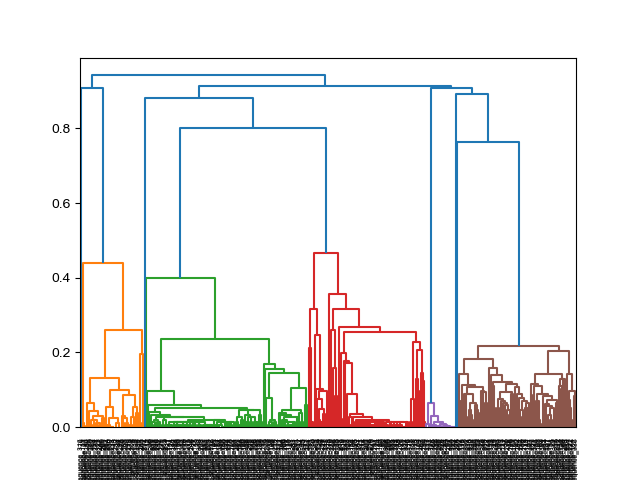

In [118]:

from scipy.spatial.distance import squareform

plt.close('all')
# np.random.seed(1)
# numleaf = 200
# _alphabets = [chr(i) for i in range(97, 97 + 24)]
# labels = sorted(
#     ["".join(list(np.random.choice(_alphabets, 10))) for i in range(numleaf)]
# )

# x = np.random.rand(numleaf)
# D = np.zeros([numleaf, numleaf])
# for i in range(numleaf):
#     for j in range(numleaf):

#         D[i, j] = abs(x[i] - x[j])
        
# # Assuming D is computed correctly as a distance matrix
# # Ensure D is condensed
# condensed_D = squareform(D)
# print(condensed_D)
# Compute linkage using the condensed distance matrix
Y = hierarchy.linkage(distance_mat, method='complete')
# print(Y)
# Y = sch.linkage(condensed_D, method="single")
        
# print(D)
# # Y = sch.linkage(D, method="single")
# # print(Y)
Z2 = sch.dendrogram(Y, labels=symm_dist.index, no_plot=False)

In [122]:
sorted_muscle_df.loc['sequence_304']

sequence_1      12.42
sequence_2      16.02
sequence_3      10.96
sequence_4      10.76
sequence_5      14.38
                ...  
sequence_407    10.37
sequence_408    11.11
sequence_409    14.94
sequence_410    13.10
sequence_411    14.29
Name: sequence_304, Length: 411, dtype: float64

In [129]:
# type_list = ["ex" + str(i) for i in range(type_num)]
muscl

{'example_color': ['ex4', 'ex4', 'ex1', 'ex2', 'ex3', 'ex4', 'ex2', 'ex1', 'ex4', 'ex0', 'ex5', 'ex3', 'ex1', 'ex4', 'ex0', 'ex0', 'ex4', 'ex1', 'ex3', 'ex4', 'ex1', 'ex3', 'ex4', 'ex2', 'ex4', 'ex2', 'ex2', 'ex1', 'ex0', 'ex0', 'ex4', 'ex0', 'ex2', 'ex3', 'ex5', 'ex2', 'ex1', 'ex5', 'ex5', 'ex2', 'ex3', 'ex0', 'ex0', 'ex3', 'ex2', 'ex2', 'ex0', 'ex3', 'ex5', 'ex5', 'ex5', 'ex0', 'ex0', 'ex3', 'ex0', 'ex1', 'ex1', 'ex3', 'ex4', 'ex0', 'ex3', 'ex5', 'ex1', 'ex5', 'ex2', 'ex0', 'ex0', 'ex4', 'ex5', 'ex1', 'ex5', 'ex2', 'ex0', 'ex1', 'ex5', 'ex2', 'ex0', 'ex2', 'ex1', 'ex0', 'ex1', 'ex5', 'ex4', 'ex2', 'ex1', 'ex1', 'ex3', 'ex3', 'ex2', 'ex4', 'ex3', 'ex5', 'ex4', 'ex3', 'ex4', 'ex1', 'ex4', 'ex5', 'ex1', 'ex1', 'ex3', 'ex0', 'ex4', 'ex5', 'ex2', 'ex1', 'ex4', 'ex4', 'ex4', 'ex3', 'ex5', 'ex1', 'ex3', 'ex5', 'ex2', 'ex0', 'ex4', 'ex1', 'ex2', 'ex0', 'ex3', 'ex3', 'ex2', 'ex1', 'ex0', 'ex3', 'ex5', 'ex3', 'ex5', 'ex4', 'ex2', 'ex4', 'ex3', 'ex3', 'ex4', 'ex1', 'ex3', 'ex1', 'ex4', 'ex1', '

ERROR IS HERE


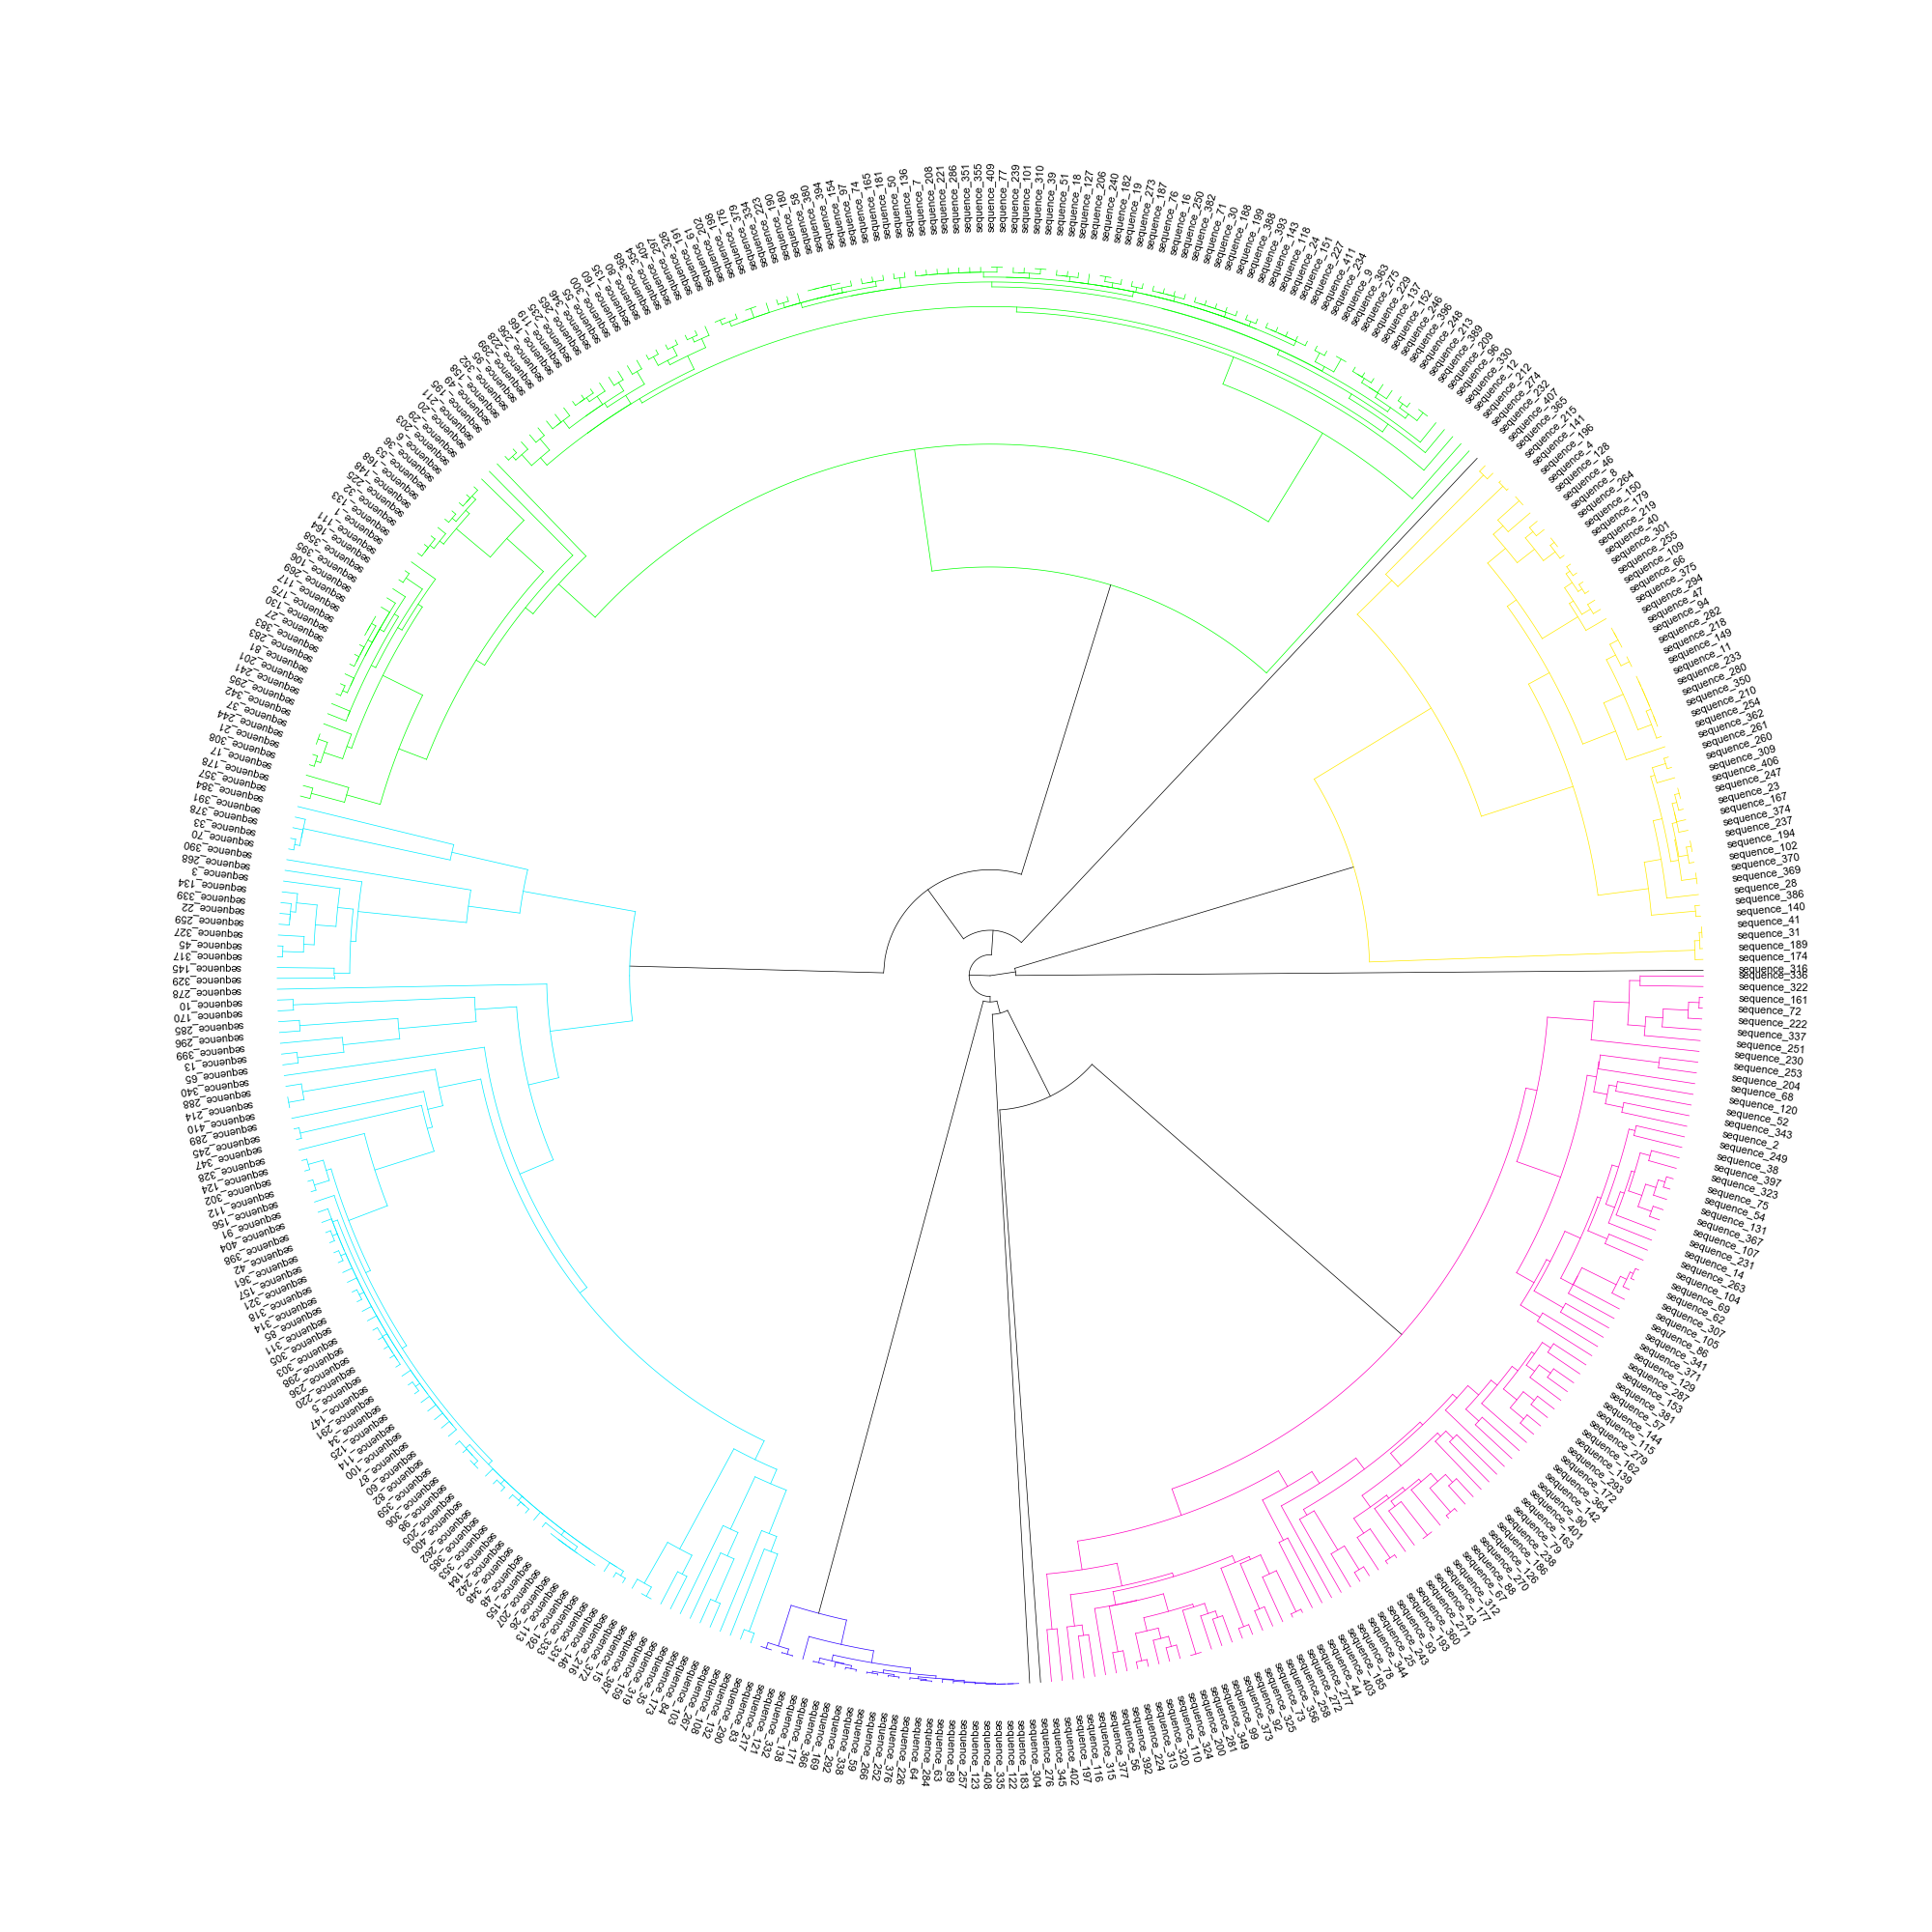

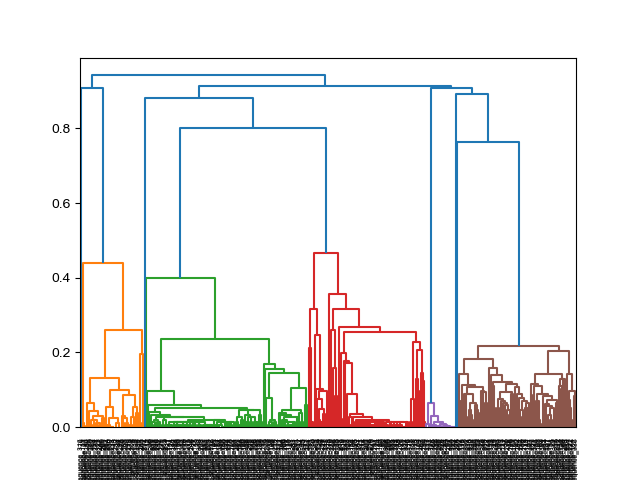

In [125]:
plt.close()
# type_num = 6
# type_list = ["ex" + str(i) for i in range(type_num)]
# sample_classes = {
#     "example_color": [np.random.choice(type_list) for i in range(numleaf)]
# }
Z2 = sch.dendrogram(Y, labels=symm_dist.index, no_plot=False)
fig, ax = plt.subplots(figsize=(20, 20))
radialTreee(Z2, ax=ax) #, sample_classes=sample_classes)
plt.show()

In [126]:
# symm_dist.loc['sequence_313']['sequence_214']
sorted_muscle_df.loc['sequence_181']['sequence_50']

99.35

In [238]:
plt.close()
# If y is a 1-D condensed distance matrix, then y must be a 
#  sized vector, where n is the number of original observations paired in the distance matrix.

# A (n-1) by 4 matrix Z is returned. (410 * 4) here
# At the ith iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster 
# A cluster with an index less than corresponds to one of the original observations. 
# The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. 
# The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.

Z = hierarchy.linkage(distance_mat, method='average')  # You can use different linkage methods
# print(Z, Z[0, 0], Z[0, 1])
# # # Plot the dendrogram
# plt.figure(figsize=(10, 5))
# dn = hierarchy.dendrogram(Z)

# plt.title('Dendrogram')
# plt.xlabel('Data Points')
# plt.ylabel('Distance')
# plt.show()

In [89]:
plt.close('all')
# sns.clustermap(muscle_df_all, vmin=20, vmax=100)
# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)
# plt.show()

In [12]:
blast_path = input_dir+'BLAST_output\\proteins_45\\'

In [32]:
main_blast_job = pd.read_json(blast_path+'0GA5FXSX01N.json')
blast_ids_list = [x['File'] for x in main_blast_job['BlastJSON']]
# blast_ids_list

In [79]:
for i in blast_ids_list:
    try:
        with open(blast_path+i) as f:
            data = json.load(f)
            hits_dict = data['BlastOutput2']['report']['results']['search']['hits']
    #         print(hits_dict)
            params = []
            for x in hits_dict:
    #             params.append()
    #             print(x['num'])
                description = pd.Series(x['description'][0])
                description['num'] = x['num']
                description['len'] = x['len']
    #             print(description)
                hsps = pd.Series(x['hsps'][0])
    #             print(hsps)
                combined = pd.concat([description, hsps])
    #             print(combined)
                params.append(combined)
    #         print(len(params))
    #         print(params[0])
            params_df = pd.concat(params, axis=1).T
    #         print(params_df)
            params_df.to_csv(blast_path+i.split('.')[0]+'.csv')
    except:
        print(i, 'DOESNT EXIS')
        pass

0GA5FXSX01N_38.json DOESNT EXIS
